In [87]:
import sys
sys.path.insert(1, '/home/kardashin/Work')
sys.path.insert(1, 'C:/Users/kardashin/Work')
from variationals import *

from scipy.stats import gaussian_kde, unitary_group, sem
from numpy import log2
from numpy.linalg import eig, eigh, norm

import seaborn as sns

from functools import reduce
from itertools import product

import time

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import rc, gridspec
matplotlib.rc('font', family='CMU Serif')
matplotlib.rcParams['mathtext.fontset'] = 'cm' 
matplotlib.rcParams['axes.unicode_minus'] = False

In [88]:
import openfermion
from openfermion.ops import FermionOperator, BinaryCode
import openfermion.utils as OU
import openfermion.hamiltonians as OH
import openfermion.transforms as OT
from openfermion.transforms import jordan_wigner, bravyi_kitaev

In [89]:
from scipy.linalg import logm

def renyi_entropy(density_matrix, a=2):
    
    d = len(density_matrix)
    evals = eigh(density_matrix)[0]
    
    entropy = 0
    for e in evals:
        if e > 0:
            entropy += e**a
    if entropy > 0:
        entropy = log2(entropy)
        
    return entropy / (1 - a) / log2(d)


def von_neumann_entropy(density_matrix):
    
    d = len(density_matrix)
    evals = eigh(density_matrix)[0]
    
    entropy = 0
    for e in evals:
        if e > 0:
            entropy -= e * log2(e)
            
    return entropy / log2(d)

In [90]:
def partial_trace(density_matrix, qubits_number, subspace_numbers_array):
    
    s0 = np.array([[1.],
                   [0.]]) # |0>
    s1 = np.array([[0.],
                   [1.]]) # |1>
    
    subspace_numbers_array = np.array(subspace_numbers_array) - np.array([1 for i in range(len(subspace_numbers_array))])
    subspace_numbers_array = sorted(subspace_numbers_array, reverse=True)
    
    traced_subspaces_counter = 0
    for subspace_number in subspace_numbers_array:
        
        for i in range(qubits_number - traced_subspaces_counter):
            operator_temp_0 = s0
            for k in range(subspace_number):
                operator_temp_0 = kron(I_np, operator_temp_0)
            for i in range(subspace_number+1, qubits_number - traced_subspaces_counter):
                operator_temp_0 = kron(operator_temp_0, I_np)

        for i in range(qubits_number - traced_subspaces_counter):
            operator_temp_1 = s1
            for k in range(subspace_number):
                operator_temp_1 = kron(I_np, operator_temp_1)
            for i in range(subspace_number+1, qubits_number - traced_subspaces_counter):
                operator_temp_1 = kron(operator_temp_1, I_np)
                
        density_matrix = operator_temp_0.conjugate().transpose().dot(density_matrix).dot(operator_temp_0) + operator_temp_1.conjugate().transpose().dot(density_matrix).dot(operator_temp_1)
        
        traced_subspaces_counter += 1
        
    return density_matrix

#### Matrix generators

In [91]:
def random_hermitian(qubits_number, distribution='uniform'):
    
    d = 2**qubits_number
    
    if distribution == 'uniform':
        hermitian = np.array([[np.random.uniform(-1, 1) for i in range(d)] for i in range(d)]) + 1.j * np.array([[np.random.uniform(-1, 1) for i in range(d)] for i in range(d)])
    if distribution == 'gaussian':
        hermitian = np.array([[np.random.normal() for i in range(d)] for i in range(d)]) + 1.j * np.array([[np.random.normal() for i in range(d)] for i in range(d)]) 

    hermitian = (hermitian + hermitian.T.conj())/2
    
    return hermitian


def exponentiate_hermitian(hermitian, t=1):
    
    unitary = expm(1.j*t*hermitian)
    
    return unitary


def reconstruct_hermitian(hermitian, multiplier):
    
    lh = len(hermitian)
    
    eigenvalues, eigenvectors = eigh(hermitian)
    
    eigenvalues = eigenvalues * multiplier
    
    new_hermitian = np.zeros((lh, lh))
    for i in range(lh):
        projector = np.outer(eigenvectors[:,i], eigenvectors[:,i].conj().T)
        new_hermitian = new_hermitian + eigenvalues[i] * projector
        
    return new_hermitian

#### Hamiltonians

In [92]:
def schwinger_model(n_qubits, w, m, g):
    
    d = 2**n_qubits
    
    sp = (X_np + 1j * Y_np) / 2
    sm = (X_np - 1j * Y_np) / 2
    
    term_1 = 1j * np.zeros((d, d))
    for j in range(n_qubits):
        k = (j + 1) % n_qubits
        crea = [I_np]*j + [sp] + [I_np]*(n_qubits - j - 1)
        anni = [I_np]*k + [sm] + [I_np]*(n_qubits - k - 1)
        crea = reduce(kron, crea)
        anni = reduce(kron, anni)
        op = crea.dot(anni)
        term_1 = term_1 + op + op.conj().T
    term_1 = w * term_1

    term_2 = 1j * np.zeros((d, d))
    for j in range(n_qubits):
        operator = [I_np]*j + [Z_np] + [I_np]*(n_qubits - 1 - j)
        term_2 = term_2 + (-1)**(j + 1) * reduce(kron, operator)
    term_2 = m / 2 * term_2

    term_3 = 1j * np.zeros((d, d))
    for j in range(n_qubits):
        L = 1j * np.zeros((d, d))
        for l in range(j + 1):
            operator = [I_np]*n_qubits
            operator[l] = Z_np + (-1)**(l + 1) * I_np
            L = L - 0.5 * reduce(kron, operator)
        term_3 = term_3 + L.dot(L)
    term_3 = g * term_3
        
    return term_1 + term_2 + term_3

In [93]:
def hubbard_model(n_qubits, t, v1, v2):
    
    d = 2**n_qubits
    
    sp = (X_np + 1j * Y_np) / 2
    sm = (X_np - 1j * Y_np) / 2
    
    term_1 = 1j * np.zeros((d, d))
    for j in range(n_qubits):
        k = (j + 1) % n_qubits
        crea = [Z_np]*j + [sp] + [I_np]*(n_qubits - j - 1)
        anni = [Z_np]*k + [sm] + [I_np]*(n_qubits - k - 1)
        crea = reduce(kron, crea)
        anni = reduce(kron, anni)
        op = crea.dot(anni)
        term_1 = term_1 + op + op.conj().T
        
    term_2 = 1j * np.zeros((d, d))
    for j in range(n_qubits):
        crea = [Z_np]*j + [sp] + [I_np]*(n_qubits - j - 1)
        anni = [Z_np]*j + [sm] + [I_np]*(n_qubits - j - 1)
        crea = reduce(kron, crea)
        anni = reduce(kron, anni)
        nu_c = crea.dot(anni)

        k = (j + 1) % n_qubits
        crea = [Z_np]*k + [sp] + [I_np]*(n_qubits - k - 1)
        anni = [Z_np]*k + [sm] + [I_np]*(n_qubits - k - 1)
        crea = reduce(kron, crea)
        anni = reduce(kron, anni)
        nu_n = crea.dot(anni)
        
        term_2 = term_2 + nu_c.dot(nu_n)
        
    term_3 = 1j * np.zeros((d, d))
    for j in range(n_qubits):
        crea = [Z_np]*j + [sp] + [I_np]*(n_qubits - j - 1)
        anni = [Z_np]*j + [sm] + [I_np]*(n_qubits - j - 1)
        crea = reduce(kron, crea)
        anni = reduce(kron, anni)
        nu_c = crea.dot(anni)
        
        k = (j + 2) % n_qubits
        crea = [Z_np]*k + [sp] + [I_np]*(n_qubits - k - 1)
        anni = [Z_np]*k + [sm] + [I_np]*(n_qubits - k - 1)
        crea = reduce(kron, crea)
        anni = reduce(kron, anni)
        nu_n = crea.dot(anni)
        
        term_3 = term_3 + nu_c.dot(nu_n)
        
    term_1 = -t * term_1
    term_2 = v1 * term_2
    term_3 = v2 * term_3
        
    return term_1 + term_2 + term_3

In [94]:
from openfermion.ops import FermionOperator, BinaryCode
import openfermion.utils as OU
import openfermion.hamiltonians as OH
import openfermion.transforms as OT
from openfermion.transforms import jordan_wigner, bravyi_kitaev
def spinless_hubbard_with_nnn(n_sites, t, V_nn, V_nnn, mu):
    """Scalar Hubbard model on a chain with next-nearest neighbour interactions"""
    hubbard_model = OH.fermi_hubbard(n_sites, 1, t, V_nn,
                                     chemical_potential=mu, periodic=True, spinless=True)
    
    for i in range(n_sites):
        op_tuple = ((i, 1), (i, 0), ((i + 2) % n_sites, 1), ((i + 2) % n_sites, 0))
        hubbard_model += FermionOperator(op_tuple, V_nnn)
    return hubbard_model
n_sites = 3
model = spinless_hubbard_with_nnn(n_sites, 1, 0, 0, 0)
jw = jordan_wigner(model)
sparse_op_jw = OT.get_sparse_operator(jw)

### Minimizers

##### Ansatz

In [7]:
def minimize_uni_ansatz(qubits_number, state_tensor_network, unitary, overlap_threshold, method, options={}):
    
    fun_values = []
    overlaps = []
    
    d = len(unitary)
    exact_eigenvectors = eig(unitary)[1]
    
    zero_state = np.array([1] + [0]*(2**qubits_number - 1))
    
    # because I can't do pointers
    state_vector_reserve = [None]
    fun_value_reserve = [None]
    
    def fun(x):        
        update_tensor_network(state_tensor_network, x)   
        state_tensor_network_matrix = tensor_network_to_matrix(qubits_number, state_tensor_network)
        state_vector = state_tensor_network_matrix.dot(zero_state)

        fun_value = 1 - abs(state_vector.conj().T.dot(unitary).dot(state_vector))**2
        
        state_vector_reserve.pop()
        fun_value_reserve.pop()
        state_vector_reserve.append(state_vector)
        fun_value_reserve.append(fun_value)
        
        return fun_value

    def callback(xk):        
        state_vector = state_vector_reserve[0]
        overlap = 0
        for i in range(d):
            overlap_i = abs(state_vector.conj().T.dot(exact_eigenvectors[:,i]))**2
            if  overlap_i > overlap:
                overlap = overlap_i
        overlaps.append(overlap)

        fun_value = fun_value_reserve[0]
        fun_values.append(fun_value)
        
        if overlap_threshold is not None:
            if overlap >= overlap_threshold:
                return True
            else:
                return False
        else:
            return None
    
    
    initial_parameters = []
    for block in state_tensor_network:
        initial_parameters += list(block["parameters"])
        
    optimization_result = minimize(fun=fun, x0=initial_parameters, callback=callback, method=method, options=options)
    
    # last iteration
    update_tensor_network(state_tensor_network, optimization_result.x)
    state_tensor_network_matrix = tensor_network_to_matrix(qubits_number, state_tensor_network)
    state_vector = state_tensor_network_matrix.dot(zero_state)
    overlap = 0
    i_max = 0
    for i in range(d):
        overlap_i = abs(state_vector.conj().T.dot(exact_eigenvectors[:,i]))**2
        if  overlap_i > overlap:
            i_max = i
            overlap = overlap_i
    overlaps.append(overlap)
    fun_value = 1 - abs(state_vector.conj().T.dot(unitary).dot(state_vector))**2
    fun_values.append(fun_value)

    return fun_values, overlaps, optimization_result, state_vector, exact_eigenvectors[:,i_max]

In [8]:
def minimize_var_ansatz(qubits_number, state_tensor_network, hermitian, overlap_threshold, method, options={}):

    fun_values = []
    overlaps = []
    
    d = len(hermitian)
    exact_eigenvectors = eig(hermitian)[1]
    
    zero_state = np.array([1] + [0]*(2**qubits_number - 1))
    
    state_vector_reserve = [None]
    fun_value_reserve = [None]
    
    def fun(x):
        
        update_tensor_network(state_tensor_network, x)
        state_tensor_network_matrix = tensor_network_to_matrix(qubits_number, state_tensor_network)
        state_vector = state_tensor_network_matrix.dot(zero_state)
        state_vector_reserve.pop()
        state_vector_reserve.append(state_vector)
        
        prod_state_vector = hermitian.dot(state_vector)
        fun_value = real(prod_state_vector.conj().T.dot(prod_state_vector)) - real(state_vector.conj().T.dot(prod_state_vector))**2
        
        
        fun_value_reserve.pop()
        fun_value_reserve.append(fun_value)
        
        return fun_value

    def callback(xk):
        state_vector = state_vector_reserve[0]        
        overlap = 0
        for i in range(d):
            overlap_i = abs(state_vector.conj().T.dot(exact_eigenvectors[:,i]))**2
            if  overlap_i > overlap:
                overlap = overlap_i
        overlaps.append(overlap)
        
        fun_value = fun_value_reserve[0]
        fun_values.append(fun_value)
        
        if overlap_threshold is not None:
            if overlap >= overlap_threshold:
                return True
            else:
                return False
        else:
            return None
    
    initial_parameters = []
    for block in state_tensor_network:
        initial_parameters += list(block["parameters"])
    
    optimization_result = minimize(fun=fun, x0=initial_parameters, callback=callback, method=method, options=options)

    # last iteration
    update_tensor_network(state_tensor_network, optimization_result.x)
    state_tensor_network_matrix = tensor_network_to_matrix(qubits_number, state_tensor_network)
    state_vector = state_tensor_network_matrix.dot(zero_state)
    overlap = 0
    i_max = 0
    for i in range(d):
        overlap_i = abs(state_vector.conj().T.dot(exact_eigenvectors[:,i]))**2
        if  overlap_i > overlap:
            i_max = i
            overlap = overlap_i
    overlaps.append(overlap)
    prod_state_vector = hermitian.dot(state_vector)
    fun_value = real(prod_state_vector.conj().T.dot(prod_state_vector)) - real(state_vector.conj().T.dot(prod_state_vector))**2
    fun_values.append(fun_value)
    
    return fun_values, overlaps, optimization_result, state_vector, exact_eigenvectors[:,i_max]

##### Components

In [9]:
def construct_vector_comp(parameters):

    state_vector = []

    for i in range(int(len(parameters)/2)):
        state_vector.append(parameters[2*i]*np.exp(1j*parameters[2*i+1]))

    return np.array(state_vector) / np.linalg.norm(state_vector)

In [10]:
def minimize_var_comp(hermitian, method, initial_parameters=None, overlap_threshold=None, options={}):

    d = len(hermitian)
    exact_eigenvectors = eig(hermitian)[1]
    
    fun_values = []
    overlaps = []
    
    state_vector_reserve = [None]
    fun_value_reserve = [None]
    
    def fun(x):
        state_vector = construct_vector_comp(x)
        
        prod_state_vector = hermitian.dot(state_vector)
        fun_value = real(prod_state_vector.conj().T.dot(prod_state_vector)) - real(state_vector.conj().T.dot(prod_state_vector))**2
        
        state_vector_reserve.pop()
        fun_value_reserve.pop()
        state_vector_reserve.append(state_vector)
        fun_value_reserve.append(fun_value)
        
        return fun_value

    def callback(xk):
        state_vector = state_vector_reserve[0]        
        overlap = 0
        for i in range(d):
            overlap_i = abs(state_vector.conj().T.dot(exact_eigenvectors[:,i]))**2
            if  overlap_i > overlap:
                overlap = overlap_i
        overlaps.append(overlap)
        
        fun_value = fun_value_reserve[0]
        fun_values.append(fun_value)
        
        if overlap_threshold is not None:
            if overlap >= overlap_threshold:
                return True
            else:
                return False
        else:
            return None
    
    if initial_parameters is None:
        initial_parameters = []
        for i in range(2*len(unitary)):
            if i % 2 == 0:
                initial_parameters.append(random.uniform(-1, 1))
            if i % 2 == 1:
                initial_parameters.append(random.uniform(-2.*pi, 2.*pi))
    
    optimization_result = minimize(fun=fun, x0=initial_parameters, callback=callback, method=method, options=options)
    
    # last iteration
    state_vector = construct_vector_comp(optimization_result.x)
    prod_state_vector = hermitian.dot(state_vector)
    fun_value = real(prod_state_vector.conj().T.dot(prod_state_vector)) - real(state_vector.conj().T.dot(prod_state_vector))**2
    fun_values.append(fun_value)
    overlap = 0
    for i in range(d):
        overlap_i = abs(state_vector.conj().T.dot(exact_eigenvectors[:,i]))**2
        if  overlap_i > overlap:
            overlap = overlap_i
    overlaps.append(overlap)
    
    return fun_values, overlaps, optimization_result, state_vector

In [11]:
def minimize_uni_comp(unitary, method, initial_parameters=None, overlap_threshold=None, options={}):
    
    d = len(unitary)
    exact_eigenvectors = eig(unitary)[1]
 
    fun_values = []
    overlaps = []
    
    state_vector_reserve = [None]
    fun_value_reserve = [None]
    
    def fun(x):
        state_vector = construct_vector_comp(x)
        fun_value = 1 - abs(state_vector.conj().T.dot(unitary).dot(state_vector))**2
        
        state_vector_reserve.pop()
        fun_value_reserve.pop()
        state_vector_reserve.append(state_vector)
        fun_value_reserve.append(fun_value)
        
        return fun_value

    evals = eig(hermitian)[0]
    
    def callback(xk):
        state_vector = state_vector_reserve[0]       
        overlap = 0
        for i in range(d):
            overlap_i = abs(state_vector.conj().T.dot(exact_eigenvectors[:,i]))**2
            if  overlap_i > overlap:
                overlap = overlap_i
        overlaps.append(overlap)
        
        fun_value = fun_value_reserve[0]
        fun_values.append(fun_value)
        
        if overlap_threshold is not None:
            if overlap >= overlap_threshold:
                return True
            else:
                return False
        else:
            return None

    if initial_parameters is None:
        initial_parameters = []
        for i in range(2 * d):
            if i % 2 == 0:
                initial_parameters.append(random.uniform(-1, 1))
            if i % 2 == 1:
                initial_parameters.append(random.uniform(-2.*pi, 2.*pi))
    
    optimization_result = minimize(fun=fun, x0=initial_parameters, callback=callback, method=method, options=options)
    
    # last iteration
    state_vector = construct_vector_comp(optimization_result.x)
    fun_value = 1 - abs(state_vector.conj().T.dot(unitary).dot(state_vector))**2
    fun_values.append(fun_value)
    overlap = 0
    for i in range(d):
        overlap_i = abs(state_vector.conj().T.dot(exact_eigenvectors[:,i]))**2
        if  overlap_i > overlap:
            overlap = overlap_i
    overlaps.append(overlap)
    
    return fun_values, overlaps, optimization_result, state_vector

# Overlap analysis (components)

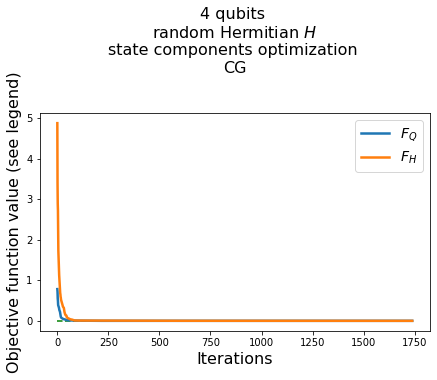

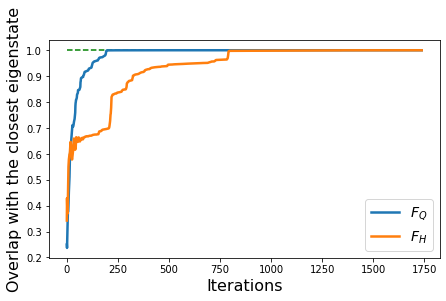

In [34]:
qubits_number = 4

method = 'CG'
options = {'maxiter': int(1e9)}

# hermitian = generate_random_hermitian(qubits_number)
hamiltonian_dictionary = ising_model(qubits_number, 1, 1); hermitian = hamiltonian_dictionary_to_matrix(hamiltonian_dictionary)
unitary = exponentiate_hermitian(hermitian, t=1)

initial_parameters = [random.uniform(-4*pi, 4*pi) for i in range((2*2**qubits_number))]
# initial_parameters = None

result_uni = minimize_uni_comp(unitary, method, initial_parameters=initial_parameters, options=options)
result_var = minimize_var_comp(hermitian, method, initial_parameters=initial_parameters, options=options)

var_function_values = list(result_var[0])
uni_function_values = list(result_uni[0])
var_overlaps = list(result_var[1])
uni_overlaps = list(result_uni[1])
maxnum = max(len(uni_function_values), len(var_function_values))
last_element = var_function_values[-1]
for i in range(len(var_function_values), maxnum):
    var_function_values.append(last_element)
last_element = uni_function_values[-1]
for i in range(len(uni_function_values), maxnum):
    uni_function_values.append(last_element)
last_element = var_overlaps[-1]
for i in range(len(var_overlaps), maxnum):
    var_overlaps.append(last_element)
last_element = uni_overlaps[-1]
for i in range(len(uni_overlaps), maxnum):
    uni_overlaps.append(last_element)
    
s = 0
k = maxnum - 1
x_axis = np.arange(0, k, 1)
plt.figure(figsize=(7, 4))
plt.plot(x_axis[s:k], uni_function_values[s:k], label=r'$F_Q$', linewidth=2.5)
plt.plot(x_axis[s:k], var_function_values[s:k], label=r'$F_H$', linewidth=2.5)
plt.hlines(y=0, xmin=s, xmax=k, colors='g', linestyles='dashed')#, label="Exact"
plt.legend(fontsize=14)
plt.xlabel('Iterations', fontsize=16)
plt.ylabel(r'Objective function value (see legend)', fontsize=16)
plt.title(str(qubits_number) + ' qubits \n' + r'random Hermitian $H$' + '\n' + 'state components optimization \n' + method + '\n\n', fontsize=16)
plt.show()
plt.figure(figsize=(7, 4))
plt.plot(x_axis[s:k], uni_overlaps[s:k], label=r'$F_Q$', linewidth=2.5)
plt.plot(x_axis[s:k], var_overlaps[s:k], label=r'$F_H$', linewidth=2.5)
plt.hlines(y=1, xmin=s, xmax=k, colors='g', linestyles='dashed')#, label="Exact"
plt.legend(fontsize=14)
plt.xlabel('Iterations', fontsize=16)
plt.ylabel(r'Overlap with the closest eigenstate', fontsize=16)
plt.show()

# Averaged (components)

In [277]:
qubits_number = 2

method = 'BFGS'
options = {'maxiter': int(1e9), 'maxfun': int(1e9), 'ftol': 1e-30}#

t = 1
runs = 100
threshold = 0.001

parameters_number = 2*2**qubits_number 
# initial_parameters_array = []
# for k in range(runs):
#     initial_parameters_temp = []
#     for i in range(parameters_number):
#         if i % 2 == 0:
#             initial_parameters_temp.append(random.uniform(-4.*np.pi, 4.*np.pi))
#         if i % 2 == 1:
#             initial_parameters_temp.append(random.uniform(-4.*np.pi, 4.*np.pi))
#     initial_parameters_array.append(initial_parameters_temp)

# hamiltonian_dictionary = ising_model(qubits_number, 1, 1)
# hamiltonian_dictionary = heisenberg_model(qubits_number, 1, 1, 1, 1)
# herm = hamiltonian_dictionary_to_matrix(hamiltonian_dictionary)
herm = schwinger_model(qubits_number, 1, 0.7, 1)
hermitians = [herm for i in range(runs)]

# hermitians = [random_hermitian(qubits_number) for i in range(runs)]
# base_evals = np.diag([i for i in range(2 ** qubits_number)])
# hermitians = []
# for i in range(runs):
#     u = unitary_group.rvs(2**qubits_number)
#     hermitians.append(u.dot(base_evals).dot(u.conj().T))

In [278]:
start_time = time.time()

uni_value_lasts = []
var_value_lasts = []
uni_overlap_lasts = []
var_overlap_lasts = []
uni_value_converged_numbers = [0]
var_value_converged_numbers = [0]
uni_overlap_converged_numbers = [0] 
var_overlap_converged_numbers = [0]
uni_value_gain = [0]
var_value_gain = [0]
uni_overlap_gain = [0]
var_overlap_gain = [0]
uni_value_distribution = []
var_value_distribution = []
uni_overlap_distribution = []
var_overlap_distribution = []
uni_value_converged_distribution = []
var_value_converged_distribution = []
uni_overlap_converged_distribution = []
var_overlap_converged_distribution = []

mn = 0
for i in range(runs):
    print('Iteration', i+1)

    hermitian = hermitians[i]
    unitary = exponentiate_hermitian(hermitian, t=t)
    initial_parameters = initial_parameters_array[i]

    uni_result = minimize_uni_comp(unitary, method, initial_parameters=initial_parameters, options=options)
    var_result = minimize_var_comp(hermitian, method, initial_parameters=initial_parameters, options=options)
    
    uni_values = uni_result[0]
    var_values = var_result[0]
    uni_overlaps = uni_result[1]
    var_overlaps = var_result[1] 

    
    uni_value_lasts.append(uni_values[-1])
    var_value_lasts.append(var_values[-1])
    uni_overlap_lasts.append(uni_overlaps[-1])
    var_overlap_lasts.append(var_overlaps[-1])
    
    
    mn = max(mn, max(len(uni_values), len(var_values)))
    
    uni_values = uni_values + [uni_values[-1]] * (mn - len(uni_values))
    var_values = var_values + [var_values[-1]] * (mn - len(var_values))
    uni_value_gain = uni_value_gain + [uni_value_gain[-1]] * (mn - len(uni_value_gain))
    var_value_gain = var_value_gain + [var_value_gain[-1]] * (mn - len(var_value_gain))
    uni_value_converged_numbers = uni_value_converged_numbers + [uni_value_converged_numbers[-1]] * (mn - len(uni_value_converged_numbers))
    var_value_converged_numbers = var_value_converged_numbers + [var_value_converged_numbers[-1]] * (mn - len(var_value_converged_numbers))
    
    uni_overlaps = uni_overlaps + [uni_overlaps[-1]] * (mn - len(uni_overlaps))
    var_overlaps = var_overlaps + [var_overlaps[-1]] * (mn - len(var_overlaps))
    uni_overlap_gain = uni_overlap_gain + [uni_overlap_gain[-1]] * (mn - len(uni_overlap_gain))
    var_overlap_gain = var_overlap_gain + [var_overlap_gain[-1]] * (mn - len(var_overlap_gain))
    uni_overlap_converged_numbers = uni_overlap_converged_numbers + [uni_overlap_converged_numbers[-1]] * (mn - len(uni_overlap_converged_numbers))
    var_overlap_converged_numbers = var_overlap_converged_numbers + [var_overlap_converged_numbers[-1]] * (mn - len(var_overlap_converged_numbers))
    
    for i in range(mn):
        uni_value_gain[i] += (uni_values[i] - uni_values[0]) / (-uni_values[0])
        var_value_gain[i] += (var_values[i] - var_values[0]) / (-var_values[0])
        uni_overlap_gain[i] += (uni_overlaps[i] - uni_overlaps[0]) / (1 - uni_overlaps[0])
        var_overlap_gain[i] += (var_overlaps[i] - var_overlaps[0]) / (1 - var_overlaps[0])
        
        if uni_values[i] <= threshold:
            uni_value_converged_numbers[i] += 1
        if var_values[i] <= threshold:
            var_value_converged_numbers[i] += 1
        if 1 - uni_overlaps[i] <= threshold:
            uni_overlap_converged_numbers[i] += 1
        if 1 - var_overlaps[i] <= threshold:
            var_overlap_converged_numbers[i] += 1   
        
    n = 0
    for value in uni_values:
        if value > threshold:
            n += 1
        else:
            break
    uni_value_converged_distribution.append(n)
    n = 0
    for value in var_values:
        if value > threshold:
            n += 1
        else:
            break
    var_value_converged_distribution.append(n)
    n = 0
    for overlap in uni_overlaps:
        if overlap < 1 - threshold:
            n = n + 1
        else:
            break
    uni_overlap_converged_distribution.append(n)
    n = 0
    for overlap in var_overlaps:
        if overlap < 1 - threshold:
            n += 1
        else:
            break
    var_overlap_converged_distribution.append(n)

    uni_value_distribution.append(uni_result[2].nit)
    var_value_distribution.append(var_result[2].nit)
    uni_overlap_distribution.append(uni_result[2].nit)
    var_overlap_distribution.append(var_result[2].nit) 
            
uni_value_gain = np.array(uni_value_gain) / runs 
var_value_gain = np.array(var_value_gain) / runs 
uni_overlap_gain = np.array(uni_overlap_gain) / runs 
var_overlap_gain = np.array(var_overlap_gain) / runs

print('Completed in ' + str(np.round(time.time()-start_time, 2)) + ' seconds.')

Iteration 1


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:56: OptimizeWarning: Unknown solver options: maxfun, ftol


ValueError: shapes (16,) and (4,4) not aligned: 16 (dim 0) != 4 (dim 0)

In [255]:
fontsize = 14

typ = 'components'
ham_lab = 'schwinger-'
rest = '1,0.7,1-'
fig_name = rest + ham_lab + str(qubits_number) + 'q-' + typ + '-' + method + '-' + 'l-' + str(runs) + 'i'
fig_name

'1,0.7,1-schwinger-4q-components-BFGS-l-100i'

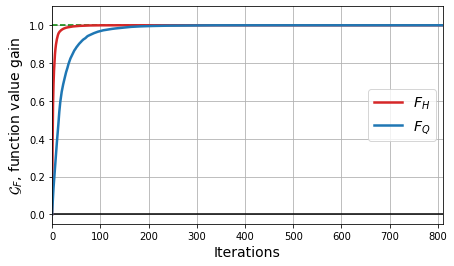

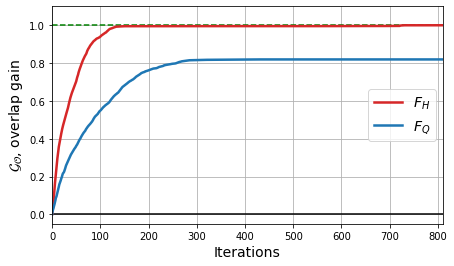

In [256]:
s = 0
k = len(var_value_gain)
x_axis = np.arange(0, k, 1)
plt.figure(figsize=(7, 4))
plt.plot(x_axis[s:k], var_value_gain[s:k], color='tab:red', label=r'$F_H$', linewidth=2.5)
plt.plot(x_axis[s:k], uni_value_gain[s:k], color='tab:blue', label=r'$F_Q$', linewidth=2.5)
plt.hlines(y=0, xmin=s, xmax=k, colors='black', linestyles='solid')
plt.hlines(y=1, xmin=s, xmax=k, colors='green', linestyles='dashed')
plt.xlim(0, k)
plt.ylim(ymax=1.1)
plt.legend(loc=5, fontsize=fontsize)
plt.grid()
plt.xlabel('Iterations', fontsize=fontsize)
plt.ylabel(r'$\mathcal{G}_F$, function value gain', fontsize=fontsize)
# plt.savefig(ham_lab + str(qubits_number) + 'qubits-' + method + '-' + str(runs) + 'instances-' + typ + '-value-gain' + '.pdf', bbox_inches='tight')
plt.show()

s = 0
k = len(var_overlap_gain)
x_axis = np.arange(0, k, 1)
plt.figure(figsize=(7, 4))
plt.plot(x_axis[s:k], var_overlap_gain[s:k], color='tab:red', label=r'$F_H$', linewidth=2.5)
plt.plot(x_axis[s:k], uni_overlap_gain[s:k], color='tab:blue', label=r'$F_Q$', linewidth=2.5)
plt.hlines(y=0, xmin=s, xmax=k, colors='black', linestyles='solid')
plt.hlines(y=1, xmin=s, xmax=k, colors='green', linestyles='dashed')
plt.xlim(s, k)
plt.ylim(ymax=1.1)
plt.legend(loc=5, fontsize=fontsize)
plt.grid()
plt.xlabel('Iterations', fontsize=fontsize)
plt.ylabel(r'$\mathcal{G}_\mathcal{O}$, overlap gain', fontsize=fontsize)
# plt.savefig(ham_lab + str(qubits_number) + 'qubits-' + method + '-' + str(runs) + 'instances-' + typ + '-overlap-gain' + '.pdf', bbox_inches='tight')
plt.show()

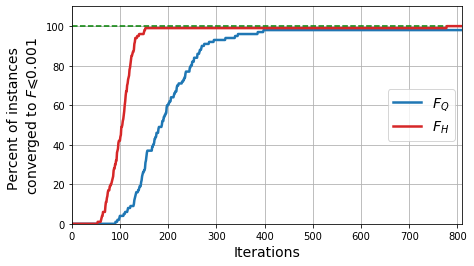

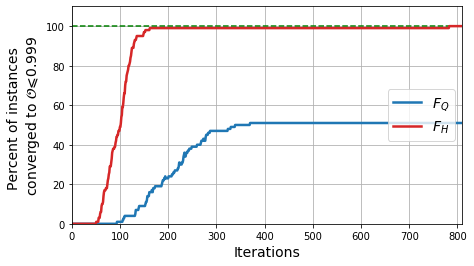

In [257]:
s = 0
k = len(uni_overlap_converged_numbers)
x_axis = np.arange(0, k, 1)

plt.figure(figsize=(7, 4))
plt.plot(x_axis[s:k], np.array(uni_value_converged_numbers[s:k])/runs*100, color='tab:blue', label=r'$F_Q$', linewidth=2.5)
plt.plot(x_axis[s:k], np.array(var_value_converged_numbers[s:k])/runs*100, color='tab:red', label=r'$F_H$', linewidth=2.5)
plt.hlines(y=100, xmin=0, xmax=k, colors='g', linestyles='dashed')#, label="Exact"
plt.legend(loc=5, fontsize=fontsize)
plt.grid()
plt.xlim(0, k)
plt.ylim(0, 110)
plt.xlabel('Iterations', fontsize=fontsize)
plt.ylabel('Percent of instances \n' + r'converged to $F \leqslant$' + str(threshold), fontsize=fontsize)
# plt.savefig(ham_lab + str(qubits_number) + 'qubits-' + method + '-' + str(runs) + 'instances-' + typ + '-value-percenage' + '.pdf', bbox_inches='tight')
plt.show()

plt.figure(figsize=(7, 4))
plt.plot(x_axis[s:k], np.array(uni_overlap_converged_numbers[s:k])/runs*100, color='tab:blue', label=r'$F_Q$', linewidth=2.5)
plt.plot(x_axis[s:k], np.array(var_overlap_converged_numbers[s:k])/runs*100, color='tab:red', label=r'$F_H$', linewidth=2.5)
plt.hlines(y=100, xmin=0, xmax=k, colors='g', linestyles='dashed')#, label="Exact"
plt.legend(loc=5, fontsize=fontsize)
plt.grid()
plt.xlim(0, k)
plt.ylim(0, 110)
plt.xlabel('Iterations', fontsize=fontsize)
plt.ylabel('Percent of instances \n' + r'converged to $\mathcal{O} \leqslant$' + str(1 - threshold), fontsize=fontsize)
# plt.savefig(ham_lab + str(qubits_number) + 'qubits-' + method + '-' + str(runs) + 'instances-' + typ + '-overlap-percenage' + '.pdf', bbox_inches='tight')
plt.show()

In [258]:
print('uni value-etropy:', np.corrcoef(uni_value_lasts, uni_entropies_exact)[0][1])
print('var value-etropy:', np.corrcoef(var_value_lasts, var_entropies_exact)[0][1])
print('uni overlap-etropy:', np.corrcoef(uni_overlap_lasts, uni_entropies_exact)[0][1])
print('var overlap-etropy:', np.corrcoef(var_overlap_lasts, var_entropies_exact)[0][1])

uni value-etropy: 0.036045804483201646
var value-etropy: -0.07392178245786542
uni overlap-etropy: 0.016724640289275554
var overlap-etropy: 0.07124283985316061


In [183]:
# bins = int(runs/5)
# plt.figure(figsize=(7, 4))
# sns.kdeplot(uni_value_converged_distribution, color='darkblue', shade=False, linewidth=3.5)
# sns.kdeplot(var_value_converged_distribution, color='darkred', shade=False, linewidth=3.5)
# plt.hist(np.sort(uni_value_converged_distribution), color='tab:blue', density=1, bins=bins, alpha=0.75, edgecolor='black', label=r'$F_Q$')
# plt.hist(np.sort(var_value_converged_distribution), color='tab:red', density=1, bins=bins, alpha=0.75, edgecolor='black', label=r'$F_H$')
# plt.legend(loc=5, fontsize=fontsize)
# #plt.grid()
# plt.xlim(xmin=0, xmax=None)
# plt.xlabel(r'Iteration of optimization termination', fontsize=fontsize)
# plt.ylabel('Density of instances \n' + r'converged to $F \leqslant$' + str(threshold), fontsize=fontsize)
# plt.savefig(ham_lab + str(qubits_number) + 'qubits-' + method + '-' + str(runs) + 'instances-' + typ + '-converged_distribution-value' + '.pdf', bbox_inches='tight')
# plt.show()

# bins = int(runs/5)
# plt.figure(figsize=(7, 4))
# sns.kdeplot(uni_overlap_converged_distribution, color='darkblue', shade=False, linewidth=3.5)
# sns.kdeplot(var_overlap_converged_distribution, color='darkred', shade=False, linewidth=3.5)
# plt.hist(np.sort(uni_overlap_converged_distribution), color='tab:blue', density=1, bins=bins, alpha=0.75, edgecolor='black', label=r'$F_Q$')
# plt.hist(np.sort(var_overlap_converged_distribution), color='tab:red', density=1, bins=bins, alpha=0.75, edgecolor='black', label=r'$F_H$')
# plt.legend(loc=5, fontsize=fontsize)
# #plt.grid()
# plt.xlim(xmin=0, xmax=None)
# plt.xlabel(r'Iteration of optimization termination', fontsize=fontsize)
# plt.ylabel('Density of instances \n' + r'converged to $\mathcal{O} \leqslant$' + str(1-threshold), fontsize=fontsize)
# # plt.savefig(ham_lab + str(qubits_number) + 'qubits-' + method + '-' + str(runs) + 'instances-' + typ + '-converged_distribution-overlap' + '.pdf', bbox_inches='tight')
# plt.show()

# # s = 0
# # k = 1500

# bins = int(runs/5)#'auto'#
# plt.figure(figsize=(7, 4))
# sns.kdeplot(uni_overlap_distribution, color='darkblue', shade=False, linewidth=3.5)
# sns.kdeplot(var_overlap_distribution, color='darkred', shade=False, linewidth=3.5)
# plt.hist(np.sort(uni_overlap_distribution), color='tab:blue', density=1, bins=bins, alpha=0.75, edgecolor='black', label=r'$F_Q$')
# plt.hist(np.sort(var_overlap_distribution), color='tab:red', density=1, bins=bins, alpha=0.75, edgecolor='black', label=r'$F_H$')
# plt.legend(loc=5, fontsize=fontsize)
# #plt.grid()
# plt.xlim(xmin=0, xmax=None)
# plt.xlabel(r'Iteration of optimization termination', fontsize=fontsize)
# plt.ylabel('Density of instances', fontsize=fontsize)
# # plt.savefig(ham_lab + str(qubits_number) + 'qubits-' + method + '-' + str(runs) + 'instances-' + typ + '-terminated_distribution' + '.pdf', bbox_inches='tight')
# plt.show()

# Averaged (ansatz)

In [23]:
qubits_number = 2
layers_number = qubits_number - 1

method = 'BFGS'
options = {}#

t = 1
runs = 300
threshold = 0.001

n_parameters = 4 * qubits_number * layers_number
initial_parameters_array = [[random.uniform(-4*pi, 4*pi) for i in range(n_parameters)] for i in range(runs)]

# hamiltonian_dictionary = ising_model(qubits_number, 1, 1)
# hamiltonian_dictionary = heisenberg_model(qubits_number, 1, 1, 1, 0)
# hamiltonian_dictionary = heisenberg_model(qubits_number, 0.5, 0.5, 0, 1)
# herm = hamiltonian_dictionary_to_matrix(hamiltonian_dictionary)
herm = schwinger_model(qubits_number, 1, -0.7, 1)
# herm = hubbard_model(qubits_number, 1, 1, 0)
# fh = OH.fermi_hubbard(qubits_number, 1, 1, 4, periodic=True, spinless=True)
# jw = jordan_wigner(fh)
# sparse_op_jw = OT.get_sparse_operator(jw)
# herm = sparse_op_jw.toarray()

# def spinless_hubbard_with_nnn(n_sites, t, V_nn, V_nnn, mu):
#     """Scalar Hubbard model on a chain with next-nearest neighbour interactions"""
#     hubbard_model = OH.fermi_hubbard(n_sites, 1, t, V_nn,
#                                      chemical_potential=mu, periodic=True, spinless=True)
# #     hubbard_model += FermionOperator(((0, 1), (n_sites - 1, 0)), -t)
# #     hubbard_model += FermionOperator(((n_sites - 1, 1), (0, 0)), -t)
#     for i in range(n_sites):
#         op_tuple = ((i, 1), (i, 0), ((i + 2) % n_sites, 1), ((i + 2) % n_sites, 0))
#         hubbard_model += FermionOperator(op_tuple, V_nnn)
#     return hubbard_model
# model = spinless_hubbard_with_nnn(qubits_number, 1, 2, 1, 0)
# jw = jordan_wigner(model)
# sparse_op_jw = OT.get_sparse_operator(jw)
# herm = sparse_op_jw.toarray()

hermitians = [herm for i in range(runs)]
# hermitians = [random_hermitian(qubits_number) for i in range(runs)]
# base_evals = np.diag([i for i in range(2 ** qubits_number)])
# hermitians = []
# for i in range(runs):
#     u = unitary_group.rvs(2**qubits_number)
#     hermitians.append(u.dot(base_evals).dot(u.conj().T))

In [24]:
start_time = time.time()

uni_value_lasts = []
var_value_lasts = []
uni_overlap_lasts = []
var_overlap_lasts = []
uni_value_converged_numbers = [0]
var_value_converged_numbers = [0]
uni_overlap_converged_numbers = [0] 
var_overlap_converged_numbers = [0]
uni_value_gain = [0]
var_value_gain = [0]
uni_overlap_gain = [0]
var_overlap_gain = [0]
uni_value_distribution = []
var_value_distribution = []
uni_overlap_distribution = []
var_overlap_distribution = []
uni_value_converged_distribution = []
var_value_converged_distribution = []
uni_overlap_converged_distribution = []
var_overlap_converged_distribution = []

uni_entropies_found = []
uni_entropies_exact = []
var_entropies_found = []
var_entropies_exact = []

mn = 0
for i in range(runs):
    start_time_local = time.time()
    print('Iteration', i+1)

    hermitian = hermitians[i]
    unitary = exponentiate_hermitian(hermitian, t=t)
    initial_parameters = initial_parameters_array[i]

    state_tensor_network_uni = hea_ansatz_eff(qubits_number, layers_number)
    update_tensor_network(state_tensor_network_uni, initial_parameters)
    state_tensor_network_var = copy.deepcopy(state_tensor_network_uni)

    uni_result = minimize_uni_ansatz(qubits_number, state_tensor_network_uni, unitary, 1-threshold, method)
    var_result = minimize_var_ansatz(qubits_number, state_tensor_network_var, hermitian, 1-threshold, method)

    uni_values = uni_result[0]
    var_values = var_result[0]
    uni_overlaps = uni_result[1]
    var_overlaps = var_result[1] 
    
    uni_value_lasts.append(uni_values[-1])
    var_value_lasts.append(var_values[-1])
    uni_overlap_lasts.append(uni_overlaps[-1])
    var_overlap_lasts.append(var_overlaps[-1])    

    mn = max(mn, max(len(uni_values), len(var_values)))
    
    uni_values = uni_values + [uni_values[-1]] * (mn - len(uni_values))
    var_values = var_values + [var_values[-1]] * (mn - len(var_values))
    uni_value_gain = uni_value_gain + [uni_value_gain[-1]] * (mn - len(uni_value_gain))
    var_value_gain = var_value_gain + [var_value_gain[-1]] * (mn - len(var_value_gain))
    uni_value_converged_numbers = uni_value_converged_numbers + [uni_value_converged_numbers[-1]] * (mn - len(uni_value_converged_numbers))
    var_value_converged_numbers = var_value_converged_numbers + [var_value_converged_numbers[-1]] * (mn - len(var_value_converged_numbers))
    
    uni_overlaps = uni_overlaps + [uni_overlaps[-1]] * (mn - len(uni_overlaps))
    var_overlaps = var_overlaps + [var_overlaps[-1]] * (mn - len(var_overlaps))
    uni_overlap_gain = uni_overlap_gain + [uni_overlap_gain[-1]] * (mn - len(uni_overlap_gain))
    var_overlap_gain = var_overlap_gain + [var_overlap_gain[-1]] * (mn - len(var_overlap_gain))
    uni_overlap_converged_numbers = uni_overlap_converged_numbers + [uni_overlap_converged_numbers[-1]] * (mn - len(uni_overlap_converged_numbers))
    var_overlap_converged_numbers = var_overlap_converged_numbers + [var_overlap_converged_numbers[-1]] * (mn - len(var_overlap_converged_numbers))
    
    for i in range(mn):
        uni_value_gain[i] += (uni_values[i] - uni_values[0]) / (-uni_values[0])
        var_value_gain[i] += (var_values[i] - var_values[0]) / (-var_values[0])
        uni_overlap_gain[i] += (uni_overlaps[i] - uni_overlaps[0]) / (1 - uni_overlaps[0])
        var_overlap_gain[i] += (var_overlaps[i] - var_overlaps[0]) / (1 - var_overlaps[0])
        
        if uni_values[i] <= threshold:
            uni_value_converged_numbers[i] += 1
        if var_values[i] <= threshold:
            var_value_converged_numbers[i] += 1
        if 1 - uni_overlaps[i] <= threshold:
            uni_overlap_converged_numbers[i] += 1
        if 1 - var_overlaps[i] <= threshold:
            var_overlap_converged_numbers[i] += 1   
        
    n = 0
    for value in uni_values:
        if value > threshold:
            n += 1
        else:
            break
    uni_value_converged_distribution.append(n)
    n = 0
    for value in var_values:
        if value > threshold:
            n += 1
        else:
            break
    var_value_converged_distribution.append(n)
    n = 0
    for overlap in uni_overlaps:
        if overlap < 1 - threshold:
            n = n + 1
        else:
            break
    uni_overlap_converged_distribution.append(n)
    n = 0
    for overlap in var_overlaps:
        if overlap < 1 - threshold:
            n += 1
        else:
            break
    var_overlap_converged_distribution.append(n)

    uni_value_distribution.append(uni_result[2].nit)
    var_value_distribution.append(var_result[2].nit)
    uni_overlap_distribution.append(uni_result[2].nit)
    var_overlap_distribution.append(var_result[2].nit)
    
    subspace_qubits = [i+1 for i in range(int(qubits_number/2))]
    
    
    uni_dm_found_r = partial_trace(np.outer(uni_result[3], uni_result[3].conj().T), qubits_number, subspace_qubits)
    var_dm_found_r = partial_trace(np.outer(var_result[3], var_result[3].conj().T), qubits_number, subspace_qubits)
    uni_dm_exact_r = partial_trace(np.outer(uni_result[4], uni_result[4].conj().T), qubits_number, subspace_qubits)
    var_dm_exact_r = partial_trace(np.outer(var_result[4], var_result[4].conj().T), qubits_number, subspace_qubits)
    uni_entropies_found.append(von_neumann_entropy(uni_dm_found_r))
    uni_entropies_exact.append(von_neumann_entropy(uni_dm_exact_r))
    var_entropies_found.append(von_neumann_entropy(var_dm_found_r))
    var_entropies_exact.append(von_neumann_entropy(var_dm_exact_r))    
    
    print('\t Completed in', time.time() - start_time_local)
            
uni_value_gain = np.array(uni_value_gain) / runs 
var_value_gain = np.array(var_value_gain) / runs 
uni_overlap_gain = np.array(uni_overlap_gain) / runs 
var_overlap_gain = np.array(var_overlap_gain) / runs

print('Completed in ' + str(np.round(time.time() - start_time, 2)) + ' seconds.')

Iteration 1


TypeError: exceptions must derive from BaseException

In [17]:
import matplotlib
from matplotlib import rc
matplotlib.rc('font', family='CMU Serif')
matplotlib.rcParams['mathtext.fontset'] = 'cm' 
matplotlib.rcParams['axes.unicode_minus'] = False

In [18]:
fontsize = 20
figsize = (7, 4)

typ = 'ansatz'
ham_lab = 'schwinger-'
rest = '1,-0.7,1-'
fig_name = rest + ham_lab + str(qubits_number) + 'q-' + typ + '-' + method + '-' + str(layers_number) + 'l-' + str(runs) + 'i'
fig_name

'1,2,1-hubbard-4q-ansatz-BFGS-3l-300i'

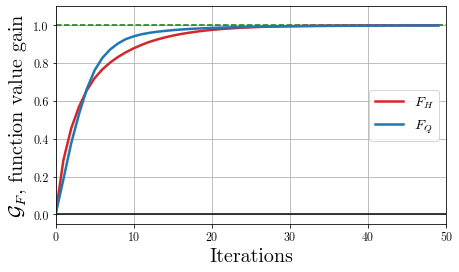

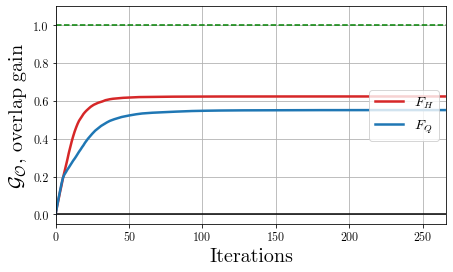

In [20]:
s = 0
k = 50#len(var_value_gain)
x_axis = np.arange(0, k, 1)
plt.figure(figsize=figsize)
plt.plot(x_axis[s:k], var_value_gain[s:k], color='tab:red', label=r'$F_H$', linewidth=2.5)
plt.plot(x_axis[s:k], uni_value_gain[s:k], color='tab:blue', label=r'$F_Q$', linewidth=2.5)
plt.hlines(y=0, xmin=s, xmax=k, colors='black', linestyles='solid')
plt.hlines(y=1, xmin=s, xmax=k, colors='green', linestyles='dashed')
plt.xlim(0, k)
plt.ylim(ymax=1.1)
plt.legend(loc=5, fontsize=14)
plt.grid()
plt.xlabel('Iterations', fontsize=fontsize)
plt.ylabel(r'$\mathcal{G}_F$, function value gain', fontsize=fontsize)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig(fig_name + '-value-gain' + '.pdf', bbox_inches='tight')
plt.savefig(fig_name + '-value-gain' + '.png', bbox_inches='tight')
plt.show()

s = 0
k = len(uni_overlap_gain)
x_axis = np.arange(0, k, 1)
plt.figure(figsize=figsize)
plt.plot(x_axis[s:k], var_overlap_gain[s:k], color='tab:red', label=r'$F_H$', linewidth=2.5)
plt.plot(x_axis[s:k], uni_overlap_gain[s:k], color='tab:blue', label=r'$F_Q$', linewidth=2.5)
plt.hlines(y=0, xmin=s, xmax=k, colors='black', linestyles='solid')
plt.hlines(y=1, xmin=s, xmax=k, colors='green', linestyles='dashed')
plt.xlim(s, k)
plt.ylim(ymax=1.1)
plt.legend(loc=5, fontsize=14)
plt.grid()
plt.xlabel('Iterations', fontsize=fontsize)
plt.ylabel(r'$\mathcal{G}_\mathcal{O}$, overlap gain', fontsize=fontsize)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig(fig_name + '-overlap-gain' + '.pdf', bbox_inches='tight')
plt.savefig(fig_name + '-overlap-gain' + '.png', bbox_inches='tight')
plt.show()

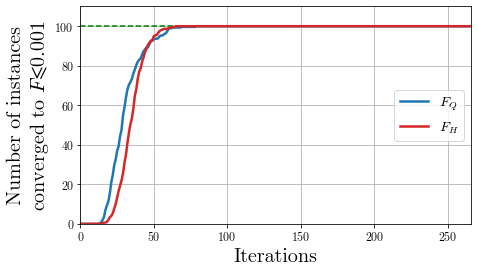

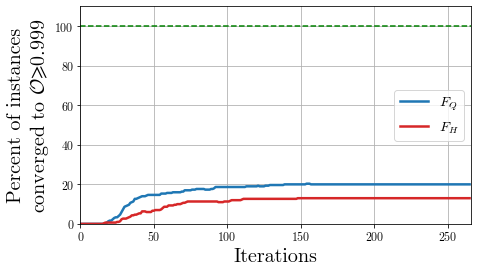

In [21]:
x_axis = np.arange(0, len(uni_overlap_converged_numbers), 1)

s = 0
k = len(uni_overlap_converged_numbers)

plt.figure(figsize=(7, 4))
plt.plot(x_axis[s:k], np.array(uni_value_converged_numbers[s:k])/runs*100, color='tab:blue', label=r'$F_Q$', linewidth=2.5)
plt.plot(x_axis[s:k], np.array(var_value_converged_numbers[s:k])/runs*100, color='tab:red', label=r'$F_H$', linewidth=2.5)
plt.hlines(y=100, xmin=0, xmax=k, colors='g', linestyles='dashed')#, label="Exact"
plt.legend(loc=5, fontsize=14)
plt.grid()
plt.xlim(0, k)
plt.ylim(0, 110)
plt.xlabel('Iterations', fontsize=fontsize)
plt.ylabel('Number of instances\n' + r'converged to $F \leqslant$' + str(threshold), fontsize=fontsize)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig(fig_name + '-value-percenage' + '.pdf', bbox_inches='tight')
plt.savefig(fig_name + '-value-percenage' + '.png', bbox_inches='tight')
plt.show()

k = len(uni_overlap_converged_numbers)
plt.figure(figsize=(7, 4))
plt.plot(x_axis[s:k], np.array(uni_overlap_converged_numbers[s:k])/runs*100, color='tab:blue', label=r'$F_Q$', linewidth=2.5)
plt.plot(x_axis[s:k], np.array(var_overlap_converged_numbers[s:k])/runs*100, color='tab:red', label=r'$F_H$', linewidth=2.5)
plt.hlines(y=100, xmin=0, xmax=k, colors='g', linestyles='dashed')#, label="Exact"
plt.legend(loc=5, fontsize=14)
plt.grid()
plt.xlim(0, k)
plt.ylim(0, 110)
plt.xlabel('Iterations', fontsize=fontsize)
plt.ylabel('Percent of instances\n' + r'converged to $\mathcal{O} \geqslant$' + str(1 - threshold), fontsize=fontsize)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig(fig_name + '-overlap-percenage' + '.pdf', bbox_inches='tight')
plt.savefig(fig_name + '-overlap-percenage' + '.png', bbox_inches='tight')
plt.show()

In [22]:
print('uni value-etropy:', np.corrcoef(uni_value_lasts, uni_entropies_exact)[0][1])
print('var value-etropy:', np.corrcoef(var_value_lasts, var_entropies_exact)[0][1])
print('uni overlap-etropy:', np.corrcoef(uni_overlap_lasts, uni_entropies_exact)[0][1])
print('var overlap-etropy:', np.corrcoef(var_overlap_lasts, var_entropies_exact)[0][1])

uni value-etropy: -0.15263978025987004
var value-etropy: -0.017335557630507023
uni overlap-etropy: -0.43015801663525244
var overlap-etropy: -0.4076597299462657


In [175]:
# bins = int(runs/5)
# plt.figure(figsize=(7, 4))
# # sns.kdeplot(uni_value_converged_distribution, color='darkblue', shade=False, linewidth=3.5)
# # sns.kdeplot(var_value_converged_distribution, color='darkred', shade=False, linewidth=3.5)
# plt.hist(np.sort(uni_value_converged_distribution), color='tab:blue', density=1, bins=bins, alpha=0.75, edgecolor='black', label=r'$F_Q$')
# plt.hist(np.sort(var_value_converged_distribution), color='tab:red', density=1, bins=bins, alpha=0.75, edgecolor='black', label=r'$F_H$')
# plt.legend(loc=5, fontsize=fontsize)
# #plt.grid()
# plt.xlim(xmin=0, xmax=None)
# plt.xlabel(r'Iteration of convergance', fontsize=fontsize)
# plt.ylabel('Density of instances \n' + r'converged to $F \leqslant$' + str(threshold), fontsize=fontsize)
# plt.savefig(fig_name + '-converged_distribution-value' + '.pdf', bbox_inches='tight')
# plt.show()

# bins = int(runs/5)
# plt.figure(figsize=(7, 4))
# # sns.kdeplot(uni_overlap_converged_distribution, color='darkblue', shade=False, linewidth=3.5)
# # sns.kdeplot(var_overlap_converged_distribution, color='darkred', shade=False, linewidth=3.5)
# plt.hist(np.sort(uni_overlap_converged_distribution), color='tab:blue', density=1, bins=bins, alpha=0.75, edgecolor='black', label=r'$F_Q$')
# plt.hist(np.sort(var_overlap_converged_distribution), color='tab:red', density=1, bins=bins, alpha=0.75, edgecolor='black', label=r'$F_H$')
# plt.legend(loc=5, fontsize=fontsize)
# #plt.grid()
# plt.xlim(xmin=0, xmax=None)
# plt.xlabel(r'Iteration of convergance', fontsize=fontsize)
# plt.ylabel('Density of instances \n' + r'converged to $\mathcal{O} \leqslant$' + str(1-threshold), fontsize=fontsize)
# plt.savefig(fig_name + '-converged_distribution-overlap' + '.pdf', bbox_inches='tight')
# plt.show()

# # s = 0
# # k = 1500

# bins = int(runs/5)#'auto'#
# plt.figure(figsize=(7, 4))
# sns.kdeplot(uni_overlap_distribution, color='darkblue', shade=False, linewidth=3.5)
# sns.kdeplot(var_overlap_distribution, color='darkred', shade=False, linewidth=3.5)
# plt.hist(np.sort(uni_overlap_distribution), color='tab:blue', density=1, bins=bins, alpha=0.75, edgecolor='black', label=r'$F_Q$')
# plt.hist(np.sort(var_overlap_distribution), color='tab:red', density=1, bins=bins, alpha=0.75, edgecolor='black', label=r'$F_H$')
# plt.legend(loc=5, fontsize=fontsize)
# #plt.grid()
# plt.xlim(xmin=125, xmax=200)
# plt.xlabel(r'Iteration of optimization termination', fontsize=fontsize)
# plt.ylabel('Density of instances', fontsize=fontsize)
# plt.savefig(fig_name + '-terminated_distribution' + '.pdf', bbox_inches='tight')
# plt.show()

In [ ]:
# file = open(str(qubits_number) + 'qubits-' + method + '-' + str(runs) + 'instances-' + typ + '-' + 'uni_value_gain.txt', 'w+')
# for el in uni_value_gain:
#     file.write('%.12f ' % el)
# file.close()
# file = open(str(qubits_number) + 'qubits-' + method + '-' + str(runs) + 'instances-' + typ + '-' + 'var_value_gain.txt', 'w+')
# for el in var_value_gain:
#     file.write('%.12f ' % el)
# file.close()

# file = open(str(qubits_number) + 'qubits-' + method + '-' + str(runs) + 'instances-' + typ + '-' + 'uni_overlap_gain.txt', 'w+')
# for el in uni_overlap_gain:
#     file.write('%.12f ' % el)
# file.close()
# file = open(str(qubits_number) + 'qubits-' + method + '-' + str(runs) + 'instances-' + typ + '-' + 'var_overlap_gain.txt', 'w+')
# for el in var_overlap_gain:
#     file.write('%.12f ' % el)
# file.close()

# file = open(str(qubits_number) + 'qubits-' + method + '-' + str(runs) + 'instances-' + typ + '-' + 'uni_value_converged_numbers.txt', 'w+')
# for el in uni_value_converged_numbers:
#     file.write('%.12f ' % el)
# file.close()
# file = open(str(qubits_number) + 'qubits-' + method + '-' + str(runs) + 'instances-' + typ + '-' + 'var_value_converged_numbers.txt', 'w+')
# for el in var_value_converged_numbers:
#     file.write('%.12f ' % el)
# file.close()

# file = open(str(qubits_number) + 'qubits-' + method + '-' + str(runs) + 'instances-' + typ + '-' + 'uni_overlap_converged_numbers.txt', 'w+')
# for el in uni_overlap_converged_numbers:
#     file.write('%.12f ' % el)
# file.close()
# file = open(str(qubits_number) + 'qubits-' + method + '-' + str(runs) + 'instances-' + typ + '-' + 'var_overlap_converged_numbers.txt', 'w+')
# for el in var_overlap_converged_numbers:
#     file.write('%.12f ' % el)
# file.close()

# file = open(str(qubits_number) + 'qubits-' + method + '-' + str(runs) + 'instances-' + typ + '-' + 'uni_value_converged_distribution.txt', 'w+')
# for el in uni_value_converged_distribution:
#     file.write('%.12f ' % el)
# file.close()
# file = open(str(qubits_number) + 'qubits-' + method + '-' + str(runs) + 'instances-' + typ + '-' + 'var_value_converged_distribution.txt', 'w+')
# for el in var_value_converged_distribution:
#     file.write('%.12f ' % el)
# file.close()

# file = open(str(qubits_number) + 'qubits-' + method + '-' + str(runs) + 'instances-' + typ + '-' + 'uni_overlap_converged_distribution.txt', 'w+')
# for el in uni_overlap_converged_distribution:
#     file.write('%.12f ' % el)
# file.close()
# file = open(str(qubits_number) + 'qubits-' + method + '-' + str(runs) + 'instances-' + typ + '-' + 'var_overlap_converged_distribution.txt', 'w+')
# for el in var_overlap_converged_distribution:
#     file.write('%.12f ' % el)
# file.close()

# Intereigenvalue distance (ansatz)

In [99]:
qubits_number = 4
layers_number = qubits_number - 1

method = 'BFGS'
options = {}#

t = 1
runs = 300
threshold = 0.001
multipliers = [0.1, 1.0, 10]

n_parameters = 4 * qubits_number * layers_number
initial_parameters_array = [[random.uniform(-4*pi, 4*pi) for i in range(n_parameters)] for i in range(runs)]

hermitians = [random_hermitian(qubits_number) for i in range(runs)]

In [120]:
fontsize = 14

typ = 'ansatz'
ham_lab = 'random-'
rest = ''
fig_name = rest + ham_lab + str(qubits_number) + 'q-' + typ + '-' + method + '-' + str(layers_number) + 'l-' + str(runs) + 'i'
fig_name

'random-3q-ansatz-BFGS-2l-3i'

In [119]:
global_start_time = time.time()

uni_value_converged_numbers_array = []
var_value_converged_numbers_array = []
uni_overlap_converged_numbers_array = []
var_overlap_converged_numbers_array = []
uni_value_gain_array = []
var_value_gain_array = []
uni_overlap_gain_array = []
var_overlap_gain_array = []
var_last_values_array = []
uni_last_values_array = []
var_last_overlaps_array = []
uni_last_overlaps_array = []

uni_entropies_found_array = []
uni_entropies_exact_array = []
var_entropies_found_array = []
var_entropies_exact_array = []

for m in multipliers:
    
    start_time = time.time()
    
    print('m =', m)

    start_time = time.time()

    uni_value_lasts = []
    var_value_lasts = []
    uni_overlap_lasts = []
    var_overlap_lasts = []
    uni_value_converged_numbers = [0]
    var_value_converged_numbers = [0]
    uni_overlap_converged_numbers = [0] 
    var_overlap_converged_numbers = [0]
    uni_value_gain = [0]
    var_value_gain = [0]
    uni_overlap_gain = [0]
    var_overlap_gain = [0]

    uni_entropies_found = []
    uni_entropies_exact = []
    var_entropies_found = []
    var_entropies_exact = []

    mn = 0
    for i in range(runs):
        start_time_local = time.time()
        print('\t Iteration', i+1)

        hermitian = m * hermitians[i]
        unitary = exponentiate_hermitian(hermitian, t=t)
        initial_parameters = initial_parameters_array[i]

        state_tensor_network_uni = hea_ansatz_eff(qubits_number, layers_number)
        update_tensor_network(state_tensor_network_uni, initial_parameters)
        state_tensor_network_var = copy.deepcopy(state_tensor_network_uni)

        uni_result = minimize_uni_ansatz(qubits_number, state_tensor_network_uni, unitary, 1-threshold, method)
        var_result = minimize_var_ansatz(qubits_number, state_tensor_network_var, hermitian, 1-threshold, method)

        uni_values = uni_result[0]
        var_values = var_result[0]
        uni_overlaps = uni_result[1]
        var_overlaps = var_result[1] 

        uni_value_lasts.append(uni_values[-1])
        var_value_lasts.append(var_values[-1])
        uni_overlap_lasts.append(uni_overlaps[-1])
        var_overlap_lasts.append(var_overlaps[-1])    

        mn = max(mn, max(len(uni_values), len(var_values)))

        uni_values = uni_values + [uni_values[-1]] * (mn - len(uni_values))
        var_values = var_values + [var_values[-1]] * (mn - len(var_values))
        uni_value_gain = uni_value_gain + [uni_value_gain[-1]] * (mn - len(uni_value_gain))
        var_value_gain = var_value_gain + [var_value_gain[-1]] * (mn - len(var_value_gain))
        uni_value_converged_numbers = uni_value_converged_numbers + [uni_value_converged_numbers[-1]] * (mn - len(uni_value_converged_numbers))
        var_value_converged_numbers = var_value_converged_numbers + [var_value_converged_numbers[-1]] * (mn - len(var_value_converged_numbers))

        uni_overlaps = uni_overlaps + [uni_overlaps[-1]] * (mn - len(uni_overlaps))
        var_overlaps = var_overlaps + [var_overlaps[-1]] * (mn - len(var_overlaps))
        uni_overlap_gain = uni_overlap_gain + [uni_overlap_gain[-1]] * (mn - len(uni_overlap_gain))
        var_overlap_gain = var_overlap_gain + [var_overlap_gain[-1]] * (mn - len(var_overlap_gain))
        uni_overlap_converged_numbers = uni_overlap_converged_numbers + [uni_overlap_converged_numbers[-1]] * (mn - len(uni_overlap_converged_numbers))
        var_overlap_converged_numbers = var_overlap_converged_numbers + [var_overlap_converged_numbers[-1]] * (mn - len(var_overlap_converged_numbers))

        for i in range(mn):
            uni_value_gain[i] += (uni_values[i] - uni_values[0]) / (-uni_values[0])
            var_value_gain[i] += (var_values[i] - var_values[0]) / (-var_values[0])
            uni_overlap_gain[i] += (uni_overlaps[i] - uni_overlaps[0]) / (1 - uni_overlaps[0])
            var_overlap_gain[i] += (var_overlaps[i] - var_overlaps[0]) / (1 - var_overlaps[0])

            if uni_values[i] <= threshold:
                uni_value_converged_numbers[i] += 1
            if var_values[i] <= threshold:
                var_value_converged_numbers[i] += 1
            if 1 - uni_overlaps[i] <= threshold:
                uni_overlap_converged_numbers[i] += 1
            if 1 - var_overlaps[i] <= threshold:
                var_overlap_converged_numbers[i] += 1   

        subspace_qubits = [i+1 for i in range(int(qubits_number/2))]
        uni_dm_found_r = partial_trace(np.outer(uni_result[3], uni_result[3].conj().T), qubits_number, subspace_qubits)
        var_dm_found_r = partial_trace(np.outer(var_result[3], var_result[3].conj().T), qubits_number, subspace_qubits)
        uni_dm_exact_r = partial_trace(np.outer(uni_result[4], uni_result[4].conj().T), qubits_number, subspace_qubits)
        var_dm_exact_r = partial_trace(np.outer(var_result[4], var_result[4].conj().T), qubits_number, subspace_qubits)
        uni_entropies_found.append(von_neumann_entropy(uni_dm_found_r))
        uni_entropies_exact.append(von_neumann_entropy(uni_dm_exact_r))
        var_entropies_found.append(von_neumann_entropy(var_dm_found_r))
        var_entropies_exact.append(von_neumann_entropy(var_dm_exact_r))    

        print('\t\t Completed in', time.time() - start_time_local)

    uni_value_gain = np.array(uni_value_gain) / runs 
    var_value_gain = np.array(var_value_gain) / runs 
    uni_overlap_gain = np.array(uni_overlap_gain) / runs 
    var_overlap_gain = np.array(var_overlap_gain) / runs

    uni_value_converged_numbers_array.append(uni_value_converged_numbers)
    var_value_converged_numbers_array.append(var_value_converged_numbers)
    uni_overlap_converged_numbers_array.append(uni_overlap_converged_numbers)
    var_overlap_converged_numbers_array.append(var_overlap_converged_numbers)
    uni_value_gain_array.append(uni_value_gain)
    var_value_gain_array.append(var_value_gain)
    uni_overlap_gain_array.append(uni_overlap_gain)
    var_overlap_gain_array.append(var_overlap_gain)
    
    var_last_values_array.append(var_values)
    uni_last_values_array.append(uni_values)
    var_last_overlaps_array.append(var_overlaps)
    uni_last_overlaps_array.append(uni_overlaps)
    
    uni_entropies_found_array = []
    uni_entropies_exact_array = []
    var_entropies_found_array = []
    var_entropies_exact_array = []
    
    print('\t Completed in ' + str(time.time()-start_time) + ' seconds.')
    
print('Completed in ' + str(np.round(time.time()-global_start_time, 2)) + ' seconds.')

m = 0.1
	 Iteration 1
		 Completed in 17.59361481666565
	 Iteration 2
		 Completed in 11.120187520980835
	 Iteration 3
		 Completed in 22.081862688064575
Completed in 50.79666352272034 seconds.
m = 1.0
	 Iteration 1
		 Completed in 9.1809401512146
	 Iteration 2
		 Completed in 4.013006210327148
	 Iteration 3
		 Completed in 8.260179281234741
Completed in 21.45513081550598 seconds.
m = 10
	 Iteration 1
		 Completed in 8.216789484024048
	 Iteration 2
		 Completed in 7.353234052658081
	 Iteration 3
		 Completed in 9.425817251205444
Completed in 24.995840787887573 seconds.
Completed in 97.25 seconds.


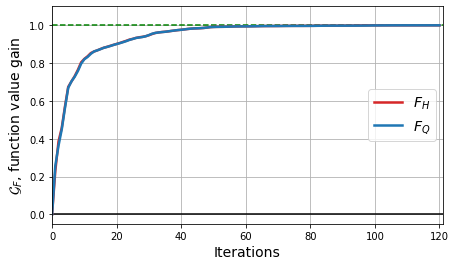

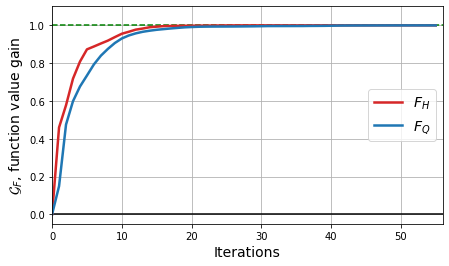

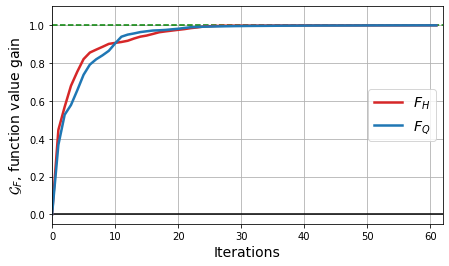

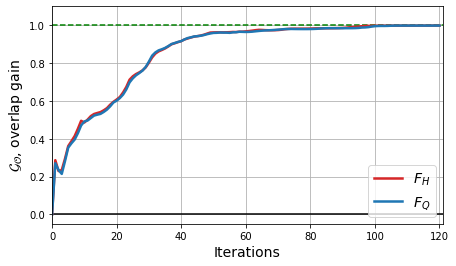

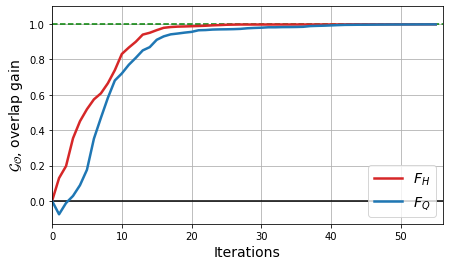

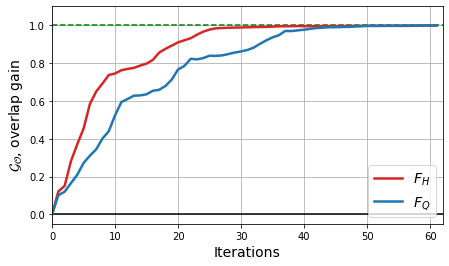

In [111]:
for i in range(len(multipliers)):
    s = 0
    k = len(var_value_gain_array[i])
    x_axis = np.arange(0, k, 1)
    plt.figure(figsize=(7, 4))
    plt.plot(x_axis[s:k], var_value_gain_array[i][s:k], color='tab:red', label=r'$F_H$', linewidth=2.5)
    plt.plot(x_axis[s:k], uni_value_gain_array[i][s:k], color='tab:blue', label=r'$F_Q$', linewidth=2.5)
    plt.hlines(y=0, xmin=s, xmax=k, colors='black', linestyles='solid')
    plt.hlines(y=1, xmin=s, xmax=k, colors='green', linestyles='dashed')
    plt.xlim(0, k)
    plt.ylim(ymax=1.1)
    plt.legend(loc=5, fontsize=fontsize)
    plt.grid()
    plt.xlabel('Iterations', fontsize=fontsize)
    plt.ylabel(r'$\mathcal{G}_F$, function value gain', fontsize=fontsize)
    plt.savefig(fig_name + '-value-gain-' + str(multipliers[i]) + 'm' + '.pdf', bbox_inches='tight')
    plt.show()

for i in range(len(multipliers)):
    s = 0
    k = len(var_overlap_gain_array[i])
    x_axis = np.arange(0, k, 1)
    plt.figure(figsize=(7, 4))
    plt.plot(x_axis[s:k], var_overlap_gain_array[i][s:k], color='tab:red', label=r'$F_H$', linewidth=2.5)
    plt.plot(x_axis[s:k], uni_overlap_gain_array[i][s:k], color='tab:blue', label=r'$F_Q$', linewidth=2.5)
    plt.hlines(y=0, xmin=s, xmax=k, colors='black', linestyles='solid')
    plt.hlines(y=1, xmin=s, xmax=k, colors='green', linestyles='dashed')
    plt.xlim(s, k)
    plt.ylim(ymax=1.1)
    plt.legend(loc=4, fontsize=fontsize)
    plt.grid()
    plt.xlabel('Iterations', fontsize=fontsize)
    plt.ylabel(r'$\mathcal{G}_\mathcal{O}$, overlap gain', fontsize=fontsize)
    plt.savefig(fig_name + '-overlap-gain-' + str(multipliers[i]) + 'm' + '.pdf', bbox_inches='tight')
    plt.show()

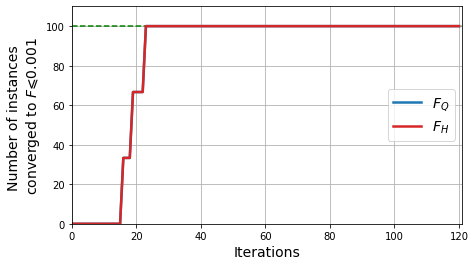

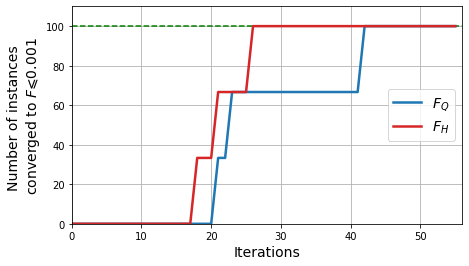

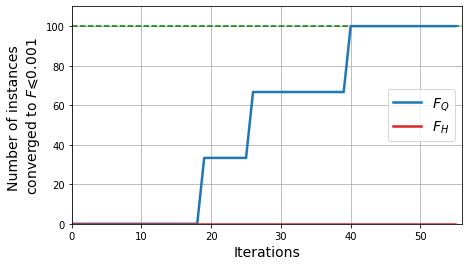

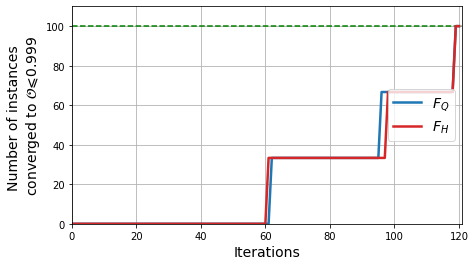

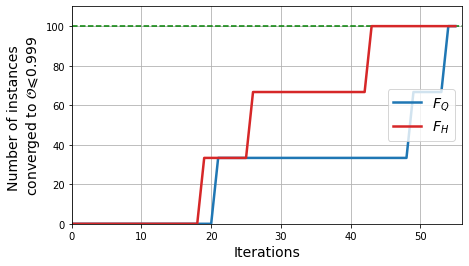

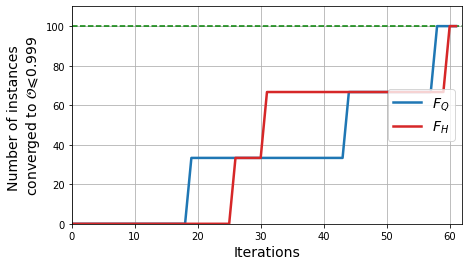

In [118]:
for i in range(len(multipliers)):
    s = 0
    k = len(uni_value_converged_numbers_array[i][s:k])
    x_axis = np.arange(0, k, 1)
    plt.figure(figsize=(7, 4))
    plt.plot(x_axis[s:k], np.array(uni_value_converged_numbers_array[i][s:k])/runs*100, color='tab:blue', label=r'$F_Q$', linewidth=2.5)
    plt.plot(x_axis[s:k], np.array(var_value_converged_numbers_array[i][s:k])/runs*100, color='tab:red', label=r'$F_H$', linewidth=2.5)
    plt.hlines(y=100, xmin=0, xmax=k, colors='g', linestyles='dashed')#, label="Exact"
    plt.legend(loc=5, fontsize=fontsize)
    plt.grid()
    plt.xlim(0, k)
    plt.ylim(0, 110)
    plt.xlabel('Iterations', fontsize=fontsize)
    plt.ylabel('Number of instances \n' + r'converged to $F \leqslant$' + str(threshold), fontsize=fontsize)
    plt.savefig(fig_name + '-value-percenage-' + str(multipliers[i]) + 'm' + '.pdf', bbox_inches='tight')
    plt.show()

for i in range(len(multipliers)):
    s = 0
    k = len(uni_overlap_converged_numbers_array[i])
    x_axis = np.arange(0, k, 1)
    plt.figure(figsize=(7, 4))
    plt.plot(x_axis[s:k], np.array(uni_overlap_converged_numbers_array[i][s:k])/runs*100, color='tab:blue', label=r'$F_Q$', linewidth=2.5)
    plt.plot(x_axis[s:k], np.array(var_overlap_converged_numbers_array[i][s:k])/runs*100, color='tab:red', label=r'$F_H$', linewidth=2.5)
    plt.hlines(y=100, xmin=0, xmax=k, colors='g', linestyles='dashed')#, label="Exact"
    plt.legend(loc=5, fontsize=fontsize)
    plt.grid()
    plt.xlim(0, k)
    plt.ylim(0, 110)
    plt.xlabel('Iterations', fontsize=fontsize)
    plt.ylabel('Number of instances \n' + r'converged to $\mathcal{O} \leqslant$' + str(1 - threshold), fontsize=fontsize)
    plt.savefig(fig_name + '-overlap-percenage-' + str(multipliers[i]) + 'm' + '.pdf', bbox_inches='tight')
    plt.show()

# Phase transition vicinity (components)

In [435]:
qubits_number = 4

method = 'L-BFGS-B'

t = 1
runs = 50
threshold = 0.001

parameters_number = 2 * 2**qubits_number
initial_parameters_array = [[random.uniform(-4*pi, 4*pi) for i in range(parameters_number)] for i in range(runs)]

pars = list(np.linspace(-0.1, 2.0, 22))
hermitians = []
for p in pars:
    hamiltonian_dictionary = ising_model(qubits_number, 1, p)
    herm = hamiltonian_dictionary_to_matrix(hamiltonian_dictionary)
#     fh = OH.fermi_hubbard(qubits_number, 1, 1, p, periodic=True, spinless=True)
#     jw = jordan_wigner(fh)
#     sparse_op_jw = OT.get_sparse_operator(jw)
#     herm = sparse_op_jw.toarray()
#     herm = schwinger_model(qubits_number, 1, 1, p)
    hermitians.append(herm)
unitaries = [expm(1j * t * herm) for herm in hermitians]

In [436]:
typ = 'components'
ham_lab = 'ising-'
rest = 'p(' + str(pars[0]) + ',' + str(pars[-1]) + ')-'
fig_name = rest + ham_lab + str(qubits_number) + 'q-' + typ + '-' + method + '-' + str(layers_number) + 'l-' + str(runs) + 'i'
fig_name

'p(-0.1,2.0)-ising-4q-components-L-BFGS-B-1l-50i'

In [437]:
global_start_time = time.time()

uni_values = []
var_values = []
uni_overlaps = []
var_overlaps = []
uni_convergence_nfevs = []
var_convergence_nfevs = [] 
uni_convergence_nfevs_threshold = []
var_convergence_nfevs_threshold = []

for m in range(len(pars)):
    
    start_time = time.time()
    
    uni_values_local = []
    var_values_local = []
    uni_overlaps_local = []
    var_overlaps_local = []
    uni_convergence_nfevs_local = []
    var_convergence_nfevs_local = [] 
    uni_convergence_nfevs_threshold_local = []
    var_convergence_nfevs_threshold_local = []
    
    print('m = ' + str(pars[m]))

    for i in range(runs):
        
        print('\t Iteration', i+1, end='\r')

        hermitian = hermitians[m]
        unitary = unitaries[m]
        initial_parameters = initial_parameters_array[i]

        uni_result = minimize_uni_comp(unitary, method, initial_parameters=initial_parameters, overlap_threshold=1-threshold)
        var_result = minimize_var_comp(hermitian, method, initial_parameters=initial_parameters, overlap_threshold=1-threshold)

        uni_values_local.append(uni_result[0][-1])
        var_values_local.append(var_result[0][-1])
        uni_overlaps_local.append(uni_result[1][-1])
        var_overlaps_local.append(var_result[1][-1])
        
        uni_convergence_nfevs_local.append(uni_result[2].nfev)
        var_convergence_nfevs_local.append(var_result[2].nfev)
        
        d = 0
        for overlap in uni_result[1]:
            if overlap < 1 - threshold:
                d += 1
            else:
                break
        uni_convergence_nfevs_threshold_local.append(d)
        d = 0
        for overlap in var_result[1]:
            if overlap < 1 - threshold:
                d += 1
            else:
                break
        var_convergence_nfevs_threshold_local.append(d)
        
    uni_values.append(uni_values_local)
    var_values.append(var_values_local)
    uni_overlaps.append(uni_overlaps_local)
    var_overlaps.append(var_overlaps_local)
    uni_convergence_nfevs.append(uni_convergence_nfevs_local)
    var_convergence_nfevs.append(var_convergence_nfevs_local)
    uni_convergence_nfevs_threshold.append(uni_convergence_nfevs_threshold_local)
    var_convergence_nfevs_threshold.append(var_convergence_nfevs_threshold_local)
    
    print('\t Completed in ' + str(np.round(time.time()-start_time, 2)) + ' seconds.')

print('Completed in ' + str(np.round(time.time()-global_start_time, 2)) + ' seconds.')

m = -0.1
	 Completed in 18.24 seconds.
m = 0.0
	 Completed in 2.58 seconds.8
m = 0.1
	 Completed in 18.46 seconds.
m = 0.20000000000000004
	 Completed in 48.72 seconds.
m = 0.30000000000000004
	 Completed in 47.17 seconds.
m = 0.4
	 Completed in 48.95 seconds.
m = 0.5000000000000001
	 Completed in 47.59 seconds.
m = 0.6000000000000001
	 Completed in 46.14 seconds.
m = 0.7000000000000001
	 Completed in 48.5 seconds.
m = 0.8
	 Completed in 66.35 seconds.
m = 0.9
	 Completed in 52.43 seconds.
m = 1.0
	 Completed in 54.45 seconds.
m = 1.1
	 Completed in 58.59 seconds.
m = 1.2
	 Completed in 58.82 seconds.
m = 1.3
	 Completed in 72.21 seconds.
m = 1.4
	 Completed in 77.69 seconds.
m = 1.5
	 Completed in 63.18 seconds.
m = 1.6
	 Completed in 65.78 seconds.
m = 1.7
	 Completed in 69.24 seconds.
m = 1.8
	 Completed in 85.79 seconds.
m = 1.9
	 Completed in 83.27 seconds.
m = 2.0
	 Completed in 89.4 seconds.
Completed in 1223.52 seconds.


In [438]:
fontsize = 14
figsize = (20, 4)
linewidth = None
with_legends = False
with_means = True

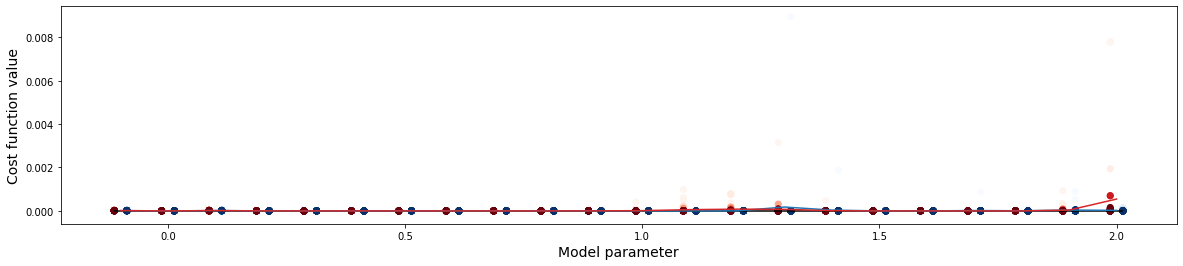

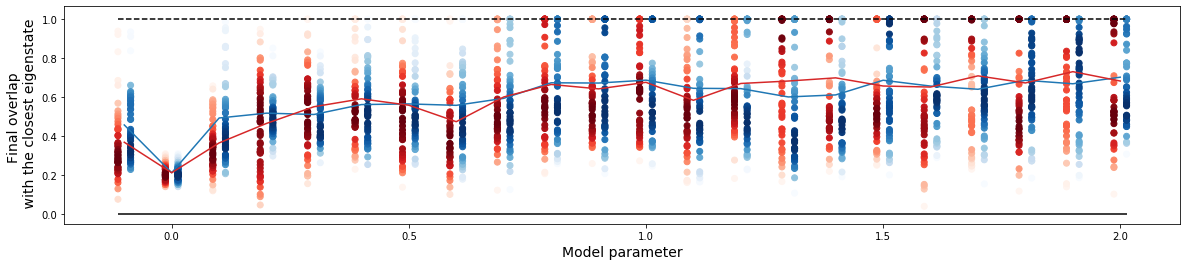

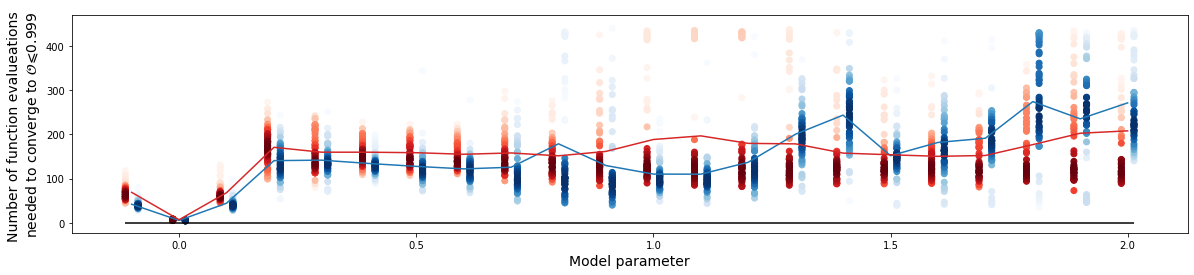

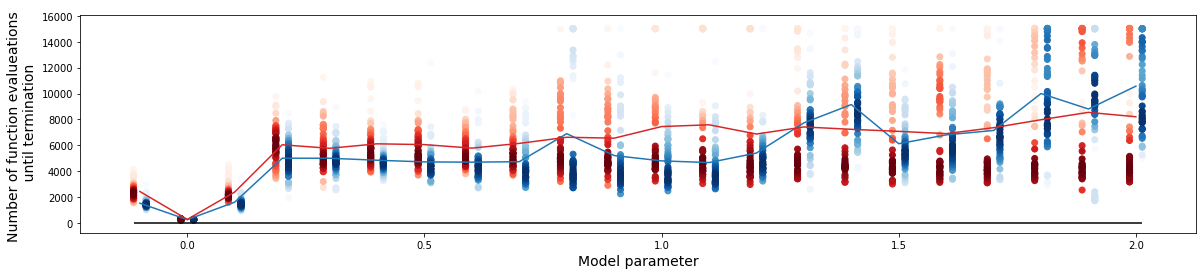

In [439]:
x_axis = pars
dif = (pars[1] - pars[0]) / 7.5
# dif = 0.0025

p = 0.0
cmap = plt.get_cmap('Blues')
colors = cmap(np.linspace(p, 1, cmap.N))
cmap_uni = LinearSegmentedColormap.from_list('part', colors)
cmap = plt.get_cmap('Reds')
colors = cmap(np.linspace(p, 1, cmap.N))
cmap_var = LinearSegmentedColormap.from_list('part', colors)


plt.figure(figsize=figsize)
if with_legends == True:
    x = np.array([x_axis[0] + dif] * len(uni_values[0]))
    e = np.array(uni_values[0])
    plt.scatter(x, e, color='tab:blue', label=r'$F_Q$', s=1)
    x = np.array([x_axis[0] - dif] * len(var_values[0]))
    e = np.array(var_values[0])
    plt.scatter(x, e, color='tab:red', label=r'$F_H$', s=1)
    plt.legend(markerscale=7, fontsize=fontsize)
if with_means == True:
    uni_means = []
    var_means = []
    for i in range(len(x_axis)):
        uni_means.append(np.mean(uni_values[i]))
        var_means.append(np.mean(var_values[i]))
    plt.plot(x_axis, uni_means, color='tab:blue', linewidth=linewidth)
    plt.plot(x_axis, var_means, color='tab:red', linewidth=linewidth)
for i in range(len(x_axis)):
    x = np.array([x_axis[i] + dif] * len(uni_values[i]))
    e = np.array(uni_values[i])
    c = gaussian_kde(uni_values[i])(uni_values[i])
    idx = c.argsort()
    x, e, c = x[idx], e[idx], c[idx]
    plt.scatter(x, e, c=c, cmap=cmap_uni)
    
    x = np.array([x_axis[i] - dif] * len(var_values[i]))
    e = np.array(var_values[i])
    c = gaussian_kde(var_values[i])(var_values[i])
    idx = c.argsort()
    x, e, c = x[idx], e[idx], c[idx]
    plt.scatter(x, e, c=c, cmap=cmap_var)
plt.xlabel('Model parameter', fontsize=fontsize)
plt.ylabel(r'Cost function value', fontsize=fontsize)
plt.hlines(y=0, xmin=x_axis[0] - dif, xmax=x_axis[-1] + dif, colors='black', linestyles='solid')
# plt.savefig('unitary_learn-' + str(n_qubits) + 'qubits-cost-layers-' + method +'-intensity.pdf', bbox_inches='tight')
plt.show()


plt.figure(figsize=figsize)
if with_legends == True:
    x = np.array([x_axis[0] + dif] * len(uni_overlaps[0]))
    e = np.array(uni_overlaps[0])
    plt.scatter(x, e, color='tab:blue', label=r'$F_Q$', s=1)
    x = np.array([x_axis[0] - dif] * len(var_overlaps[0]))
    e = np.array(var_overlaps[0])
    plt.scatter(x, e, color='tab:red', label=r'$F_H$', s=1)
    plt.legend(markerscale=7)
if with_means == True:
    uni_means = []
    var_means = []
    for i in range(len(x_axis)):
        uni_means.append(np.mean(uni_overlaps[i]))
        var_means.append(np.mean(var_overlaps[i]))
    plt.plot(x_axis, uni_means, color='tab:blue', linewidth=linewidth)
    plt.plot(x_axis, var_means, color='tab:red', linewidth=linewidth)
for i in range(len(x_axis)):
    x = np.array([x_axis[i] + dif] * len(uni_overlaps[i]))
    e = np.array(uni_overlaps[i])
    c = gaussian_kde(uni_overlaps[i])(uni_overlaps[i])
    idx = c.argsort()
    x, e, c = x[idx], e[idx], c[idx]
    plt.scatter(x, e, c=c, cmap=cmap_uni)
    
    x = np.array([x_axis[i] - dif] * len(var_overlaps[i]))
    e = np.array(var_overlaps[i])
    c = gaussian_kde(var_overlaps[i])(var_overlaps[i])
    idx = c.argsort()
    x, e, c = x[idx], e[idx], c[idx]
    plt.scatter(x, e, c=c, cmap=cmap_var)
plt.xlabel('Model parameter', fontsize=fontsize)
plt.ylabel('Final overlap \n with the closest eigenstate', fontsize=fontsize)
plt.hlines(y=0, xmin=x_axis[0] - dif, xmax=x_axis[-1] + dif, colors='black', linestyles='solid')
plt.hlines(y=1, xmin=x_axis[0] - dif, xmax=x_axis[-1] + dif, colors='black', linestyles='dashed')
# plt.grid()
# plt.savefig('unitary_learn-' + str(n_qubits) + 'qubits-cost-layers-' + method +'-intensity.pdf', bbox_inches='tight')
plt.show()


plt.figure(figsize=figsize)
if with_legends == True:
    x = np.array([x_axis[0] + dif] * len(uni_convergence_nfevs_threshold[0]))
    e = np.array(uni_convergence_nfevs_threshold[0])
    plt.scatter(x, e, color='tab:blue', label=r'$F_Q$', s=1)
    x = np.array([x_axis[0] - dif] * len(var_convergence_nfevs_threshold[0]))
    e = np.array(var_convergence_nfevs_threshold[0])
    plt.scatter(x, e, color='tab:red', label=r'$F_H$', s=1)
    plt.legend(markerscale=7, fontsize=16)
if with_means == True:
    uni_means = []
    var_means = []
    for i in range(len(x_axis)):
        uni_means.append(np.mean(uni_convergence_nfevs_threshold[i]))
        var_means.append(np.mean(var_convergence_nfevs_threshold[i]))
    plt.plot(x_axis, uni_means, color='tab:blue', linewidth=linewidth)
    plt.plot(x_axis, var_means, color='tab:red', linewidth=linewidth)
for i in range(len(x_axis)):
    x = np.array([x_axis[i] + dif] * len(uni_convergence_nfevs_threshold[i]))
    e = np.array(uni_convergence_nfevs_threshold[i])
    c = gaussian_kde(uni_convergence_nfevs_threshold[i])(uni_convergence_nfevs_threshold[i])
    idx = c.argsort()
    x, e, c = x[idx], e[idx], c[idx]
    plt.scatter(x, e, c=c, cmap=cmap_uni)
    
    x = np.array([x_axis[i] - dif] * len(var_convergence_nfevs_threshold[i]))
    e = np.array(var_convergence_nfevs_threshold[i])
    c = gaussian_kde(var_convergence_nfevs_threshold[i])(var_convergence_nfevs_threshold[i])
    idx = c.argsort()
    x, e, c = x[idx], e[idx], c[idx]
    plt.scatter(x, e, c=c, cmap=cmap_var)
plt.xlabel('Model parameter', fontsize=fontsize)
plt.ylabel('Number of function evalueations \n' + r'needed to converge to $\mathcal{O} \leqslant 0.999$', fontsize=fontsize)
plt.hlines(y=0, xmin=x_axis[0] - dif, xmax=x_axis[-1] + dif, colors='black', linestyles='solid')
# plt.grid()
# plt.savefig('unitary_learn-' + str(n_qubits) + 'qubits-cost-layers-' + method +'-intensity.pdf', bbox_inches='tight')
plt.show()


plt.figure(figsize=figsize)
if with_legends == True:
    x = np.array([x_axis[0] + dif] * len(uni_convergence_nfevs[0]))
    e = np.array(uni_convergence_nfevs[0])
    plt.scatter(x, e, color='tab:blue', label=r'$F_Q$', s=1)
    x = np.array([x_axis[0] - dif] * len(var_convergence_nfevs[0]))
    e = np.array(var_convergence_nfevs[0])
    plt.scatter(x, e, color='tab:red', label=r'$F_H$', s=1)
    plt.legend(markerscale=7, fontsize=16)
if with_means == True:
    uni_means = []
    var_means = []
    for i in range(len(x_axis)):
        uni_means.append(np.mean(uni_convergence_nfevs[i]))
        var_means.append(np.mean(var_convergence_nfevs[i]))
    plt.plot(x_axis, uni_means, color='tab:blue', linewidth=linewidth)
    plt.plot(x_axis, var_means, color='tab:red', linewidth=linewidth)
for i in range(len(x_axis)):
    x = np.array([x_axis[i] + dif] * len(uni_convergence_nfevs[i]))
    e = np.array(uni_convergence_nfevs[i])
    c = gaussian_kde(uni_convergence_nfevs[i])(uni_convergence_nfevs[i])
    idx = c.argsort()
    x, e, c = x[idx], e[idx], c[idx]
    plt.scatter(x, e, c=c, cmap=cmap_uni, label=r'$F_Q$')
        
    x = np.array([x_axis[i] - dif] * len(var_convergence_nfevs[i]))
    e = np.array(var_convergence_nfevs[i])
    c = gaussian_kde(var_convergence_nfevs[i])(var_convergence_nfevs[i])
    idx = c.argsort()
    x, e, c = x[idx], e[idx], c[idx]
    plt.scatter(x, e, c=c, cmap=cmap_var, label=r'$F_H$')
plt.xlabel('Model parameter', fontsize=fontsize)
plt.ylabel('Number of function evalueations \n until termination', fontsize=fontsize)
plt.hlines(y=0, xmin=x_axis[0] - dif, xmax=x_axis[-1] + dif, colors='black', linestyles='solid')
# plt.grid()
# plt.savefig('unitary_learn-' + str(n_qubits) + 'qubits-cost-layers-' + method +'-intensity.pdf', bbox_inches='tight')
plt.show()

# Phase transition vicinity (ansatz)

In [12]:
qubits_number = 4
layers_number = qubits_number - 1

method = 'BFGS'

t = 1
runs = 50
threshold = 0.001

n_parameters = 4 * qubits_number * layers_number
# n_parameters = 7
initial_parameters_array = [[random.uniform(-4*pi, 4*pi) for i in range(n_parameters)] for i in range(runs)]

pars = list(np.linspace(0.0, 2.0, 21))
hermitians = []
for p in pars:
    hamiltonian_dictionary = ising_model(qubits_number, 1, p)
    herm = hamiltonian_dictionary_to_matrix(hamiltonian_dictionary)
#     herm = schwinger_model(qubits_number, 1, 1, p)
#     fh = OH.fermi_hubbard(qubits_number, 1, 1, p, periodic=True, spinless=True)
#     jw = jordan_wigner(fh)
#     sparse_op_jw = OT.get_sparse_operator(jw)
#     herm = sparse_op_jw.toarray()
    hermitians.append(herm)
unitaries = [expm(1j * t * herm) for herm in hermitians]

In [13]:
typ = 'ansatz'
ham_lab = 'ising-'
rest = 'p(' + str(pars[0]) + ',' + str(pars[-1]) + ')-'
fig_name = rest + ham_lab + str(qubits_number) + 'q-' + typ + '-' + method + '-' + str(layers_number) + 'l-' + str(runs) + 'i'
fig_name

'p(0.0,2.0)-ising-4q-ansatz-BFGS-3l-50i'

In [14]:
global_start_time = time.time()

uni_values = []
var_values = []
uni_overlaps = []
var_overlaps = []
uni_convergence_nfevs = []
var_convergence_nfevs = [] 
uni_convergence_nfevs_threshold = []
var_convergence_nfevs_threshold = []

for m in range(len(pars)):
    
    start_time = time.time()
    
    uni_values_local = []
    var_values_local = []
    uni_overlaps_local = []
    var_overlaps_local = []
    uni_convergence_nfevs_local = []
    var_convergence_nfevs_local = [] 
    uni_convergence_nfevs_threshold_local = []
    var_convergence_nfevs_threshold_local = []
    
    print('Starting m = ' + str(pars[m]))

    for i in range(runs):
        
        print('\t Iteration', i+1, end='\r')

        hermitian = hermitians[m]
        unitary = unitaries[m]
        initial_parameters = initial_parameters_array[i]

        state_tensor_network_uni = hea_ansatz_eff(qubits_number, layers_number)
        update_tensor_network(state_tensor_network_uni, initial_parameters)
        state_tensor_network_var = copy.deepcopy(state_tensor_network_uni)

        uni_result = minimize_uni_ansatz(qubits_number, state_tensor_network_uni, unitary, 1-threshold, method)
        var_result = minimize_var_ansatz(qubits_number, state_tensor_network_var, hermitian, 1-threshold, method)

        uni_values_local.append(uni_result[0][-1])
        var_values_local.append(var_result[0][-1])
        uni_overlaps_local.append(uni_result[1][-1])
        var_overlaps_local.append(var_result[1][-1])
        
        uni_convergence_nfevs_local.append(uni_result[2].nfev)
        var_convergence_nfevs_local.append(var_result[2].nfev)
        
        d = 0
        for overlap in uni_result[1]:
            if overlap < 1 - threshold:
                d += 1
            else:
                break
        uni_convergence_nfevs_threshold_local.append(d)
        d = 0
        for overlap in var_result[1]:
            if overlap < 1 - threshold:
                d += 1
            else:
                break
        var_convergence_nfevs_threshold_local.append(d)
        
    uni_values.append(uni_values_local)
    var_values.append(var_values_local)
    uni_overlaps.append(uni_overlaps_local)
    var_overlaps.append(var_overlaps_local)
    uni_convergence_nfevs.append(uni_convergence_nfevs_local)
    var_convergence_nfevs.append(var_convergence_nfevs_local)
    uni_convergence_nfevs_threshold.append(uni_convergence_nfevs_threshold_local)
    var_convergence_nfevs_threshold.append(var_convergence_nfevs_threshold_local)
    
    print('\t Completed in ' + str(np.round(time.time()-start_time, 2)) + ' seconds.')

print('Completed in ' + str(np.round(time.time()-global_start_time, 2)) + ' seconds.')

Starting m = 0.0
	 Completed in 651.21 seconds.
Starting m = 0.1
	 Completed in 12897.37 seconds.
Starting m = 0.2
	 Completed in 7653.09 seconds.
Starting m = 0.30000000000000004
	 Completed in 5590.74 seconds.
Starting m = 0.4
	 Completed in 4071.35 seconds.
Starting m = 0.5
	 Completed in 3258.37 seconds.
Starting m = 0.6000000000000001
	 Completed in 2868.45 seconds.
Starting m = 0.7000000000000001
	 Completed in 3402.36 seconds.
Starting m = 0.8
	 Completed in 3116.69 seconds.
Starting m = 0.9
	 Completed in 3171.73 seconds.
Starting m = 1.0
	 Completed in 3155.25 seconds.
Starting m = 1.1
	 Completed in 3429.98 seconds.
Starting m = 1.2000000000000002
	 Completed in 3709.38 seconds.
Starting m = 1.3
	 Completed in 3637.87 seconds.
Starting m = 1.4000000000000001
	 Completed in 3537.31 seconds.
Starting m = 1.5
	 Completed in 3505.54 seconds.
Starting m = 1.6
	 Completed in 3330.27 seconds.
Starting m = 1.7000000000000002
	 Completed in 3019.41 seconds.
Starting m = 1.8
	 Complete

/home/kardashin/anaconda3/lib/python3.7/site-packages/scipy/optimize/optimize.py:1166: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (np.dot(yk, sk))


	 Completed in 5159.14 seconds.
Completed in 87574.35 seconds.


In [15]:
fontsize = 16
figsize = (12, 4)
linewidth = None
with_legends = False
with_means = False

In [16]:
typ = 'ansatz'
ham_lab = 'ising-'
rest = 'p(' + str(pars[0]) + ',' + str(pars[-1]) + ')-'
fig_name = rest + ham_lab + str(qubits_number) + 'q-' + typ + '-' + method + '-' + str(layers_number) + 'l-' + str(runs) + 'i'
fig_name

'p(0.0,2.0)-ising-4q-ansatz-BFGS-3l-50i'

findfont: Font family ['CMU Serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['CMU Serif'] not found. Falling back to DejaVu Sans.


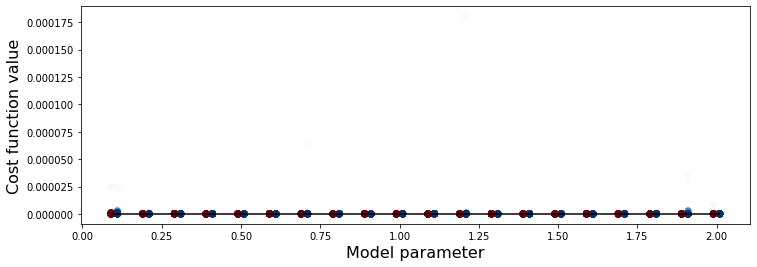

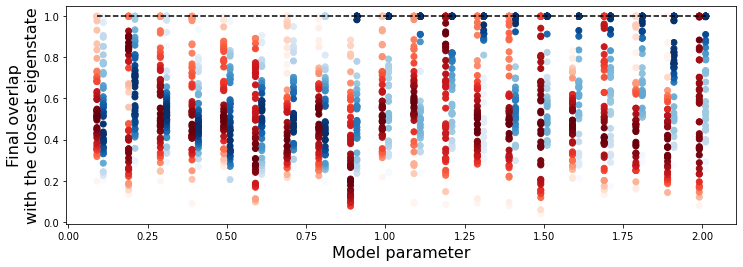

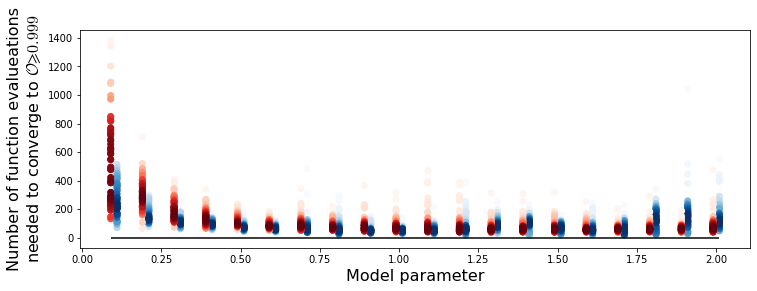

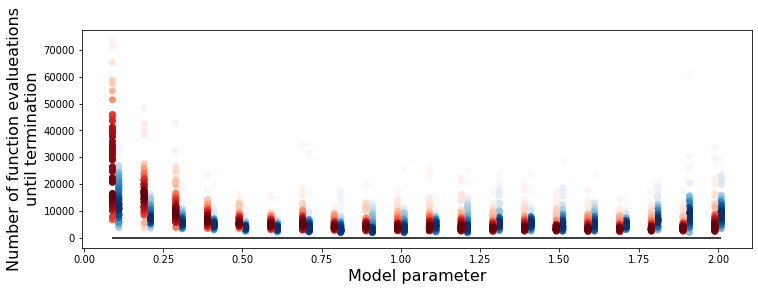

In [17]:
x_axis = pars
dif = (pars[1] - pars[0]) / 10

ss = 1

p = 0.0
cmap = plt.get_cmap('Blues')
colors = cmap(np.linspace(p, 1, cmap.N))
cmap_uni = LinearSegmentedColormap.from_list('part', colors)
cmap = plt.get_cmap('Reds')
colors = cmap(np.linspace(p, 1, cmap.N))
cmap_var = LinearSegmentedColormap.from_list('part', colors)


plt.figure(figsize=figsize)
if with_legends == True:
    x = np.array([x_axis[0] + dif] * len(uni_values[0]))
    e = np.array(uni_values[0])
    plt.scatter(x, e, color='tab:blue', label=r'$F_Q$', s=1)
    x = np.array([x_axis[0] - dif] * len(var_values[0]))
    e = np.array(var_values[0])
    plt.scatter(x, e, color='tab:red', label=r'$F_H$', s=1)
    plt.legend(markerscale=7, fontsize=fontsize)
if with_means == True:
    uni_means = []
    var_means = []
    for i in range(ss, len(x_axis)):
        uni_means.append(np.mean(uni_values[i]))
        var_means.append(np.mean(var_values[i]))
    plt.plot(x_axis[ss:], uni_means, color='tab:blue', linewidth=linewidth)
    plt.plot(x_axis[ss:], var_means, color='tab:red', linewidth=linewidth)
for i in range(ss, len(x_axis)):
    x = np.array([x_axis[i] + dif] * len(uni_values[i]))
    e = np.array(uni_values[i])
    c = gaussian_kde(uni_values[i])(uni_values[i])
    idx = c.argsort()
    x, e, c = x[idx], e[idx], c[idx]
    plt.scatter(x, e, c=c, cmap=cmap_uni)
    
    x = np.array([x_axis[i] - dif] * len(var_values[i]))
    e = np.array(var_values[i])
    c = gaussian_kde(var_values[i])(var_values[i])
    idx = c.argsort()
    x, e, c = x[idx], e[idx], c[idx]
    plt.scatter(x, e, c=c, cmap=cmap_var)
# plt.xticks(x_axis, x_axis)
plt.xlabel('Model parameter', fontsize=fontsize)
plt.ylabel(r'Cost function value', fontsize=fontsize)
plt.hlines(y=0, xmin=x_axis[ss:][0] - dif, xmax=x_axis[ss:][-1] + dif, colors='black', linestyles='solid')
plt.savefig(fig_name + '-values-' + 'intensity.pdf', bbox_inches='tight')
plt.show()


plt.figure(figsize=figsize)
if with_legends == True:
    x = np.array([x_axis[0] + dif] * len(uni_overlaps[0]))
    e = np.array(uni_overlaps[0])
    plt.scatter(x, e, color='tab:blue', label=r'$F_Q$', s=1)
    x = np.array([x_axis[0] - dif] * len(var_overlaps[0]))
    e = np.array(var_overlaps[0])
    plt.scatter(x, e, color='tab:red', label=r'$F_H$', s=1)
    plt.legend(markerscale=7)
if with_means == True:
    uni_means = []
    var_means = []
    for i in range(ss, len(x_axis)):
        uni_means.append(np.mean(uni_overlaps[i]))
        var_means.append(np.mean(var_overlaps[i]))
    plt.plot(x_axis[ss:], uni_means, color='tab:blue', linewidth=linewidth)
    plt.plot(x_axis[ss:], var_means, color='tab:red', linewidth=linewidth)
for i in range(ss, len(x_axis)):
    x = np.array([x_axis[i] + dif] * len(uni_overlaps[i]))
    e = np.array(uni_overlaps[i])
    c = gaussian_kde(uni_overlaps[i])(uni_overlaps[i])
    idx = c.argsort()
    x, e, c = x[idx], e[idx], c[idx]
    plt.scatter(x, e, c=c, cmap=cmap_uni)
    
    x = np.array([x_axis[i] - dif] * len(var_overlaps[i]))
    e = np.array(var_overlaps[i])
    c = gaussian_kde(var_overlaps[i])(var_overlaps[i])
    idx = c.argsort()
    x, e, c = x[idx], e[idx], c[idx]
    plt.scatter(x, e, c=c, cmap=cmap_var)
plt.xlabel('Model parameter', fontsize=fontsize)
plt.ylabel('Final overlap\nwith the closest eigenstate', fontsize=fontsize)
# plt.hlines(y=0, xmin=x_axis[0] - dif, xmax=x_axis[-1] + dif, colors='black', linestyles='solid')
plt.hlines(y=1, xmin=x_axis[ss:][0] - dif, xmax=x_axis[ss:][-1] + dif, colors='black', linestyles='dashed')
# plt.grid()
plt.savefig(fig_name + '-overlap-' + 'intensity.pdf', bbox_inches='tight')
plt.show()


plt.figure(figsize=figsize)
if with_legends == True:
    x = np.array([x_axis[0] + dif] * len(uni_convergence_nfevs_threshold[0]))
    e = np.array(uni_convergence_nfevs_threshold[0])
    plt.scatter(x, e, color='tab:blue', label=r'$F_Q$', s=1)
    x = np.array([x_axis[0] - dif] * len(var_convergence_nfevs_threshold[0]))
    e = np.array(var_convergence_nfevs_threshold[0])
    plt.scatter(x, e, color='tab:red', label=r'$F_H$', s=1)
    plt.legend(markerscale=7, fontsize=16)
if with_means == True:
    uni_means = []
    var_means = []
    for i in range(ss, len(x_axis)):
        uni_means.append(np.mean(uni_convergence_nfevs_threshold[i]))
        var_means.append(np.mean(var_convergence_nfevs_threshold[i]))
    plt.plot(x_axis[ss:], uni_means, color='tab:blue', linewidth=linewidth)
    plt.plot(x_axis[ss:], var_means, color='tab:red', linewidth=linewidth)
for i in range(ss, len(x_axis)):
    x = np.array([x_axis[i] + dif] * len(uni_convergence_nfevs_threshold[i]))
    e = np.array(uni_convergence_nfevs_threshold[i])
    c = gaussian_kde(uni_convergence_nfevs_threshold[i])(uni_convergence_nfevs_threshold[i])
    idx = c.argsort()
    x, e, c = x[idx], e[idx], c[idx]
    plt.scatter(x, e, c=c, cmap=cmap_uni)
    
    x = np.array([x_axis[i] - dif] * len(var_convergence_nfevs_threshold[i]))
    e = np.array(var_convergence_nfevs_threshold[i])
    c = gaussian_kde(var_convergence_nfevs_threshold[i])(var_convergence_nfevs_threshold[i])
    idx = c.argsort()
    x, e, c = x[idx], e[idx], c[idx]
    plt.scatter(x, e, c=c, cmap=cmap_var)
plt.xlabel('Model parameter', fontsize=fontsize)
plt.ylabel('Number of function evalueations\n' + r'needed to converge to $\mathcal{O} \geqslant 0.999$', fontsize=fontsize)
plt.hlines(y=0, xmin=x_axis[ss:][0] - dif, xmax=x_axis[ss:][-1] + dif, colors='black', linestyles='solid')
# plt.grid()
plt.savefig(fig_name + '-value_convergance-' + 'intensity.pdf', bbox_inches='tight')
plt.show()


plt.figure(figsize=figsize)
if with_legends == True:
    x = np.array([x_axis[0] + dif] * len(uni_convergence_nfevs[0]))
    e = np.array(uni_convergence_nfevs[0])
    plt.scatter(x, e, color='tab:blue', label=r'$F_Q$', s=1)
    x = np.array([x_axis[0] - dif] * len(var_convergence_nfevs[0]))
    e = np.array(var_convergence_nfevs[0])
    plt.scatter(x, e, color='tab:red', label=r'$F_H$', s=1)
    plt.legend(markerscale=7, fontsize=16)
if with_means == True:
    uni_means = []
    var_means = []
    for i in range(ss, len(x_axis)):
        uni_means.append(np.mean(uni_convergence_nfevs[i]))
        var_means.append(np.mean(var_convergence_nfevs[i]))
    plt.plot(x_axis[ss:], uni_means, color='tab:blue', linewidth=linewidth)
    plt.plot(x_axis[ss:], var_means, color='tab:red', linewidth=linewidth)
for i in range(ss, len(x_axis)):
    x = np.array([x_axis[i] + dif] * len(uni_convergence_nfevs[i]))
    e = np.array(uni_convergence_nfevs[i])
    c = gaussian_kde(uni_convergence_nfevs[i])(uni_convergence_nfevs[i])
    idx = c.argsort()
    x, e, c = x[idx], e[idx], c[idx]
    plt.scatter(x, e, c=c, cmap=cmap_uni, label=r'$F_Q$')
        
    x = np.array([x_axis[i] - dif] * len(var_convergence_nfevs[i]))
    e = np.array(var_convergence_nfevs[i])
    c = gaussian_kde(var_convergence_nfevs[i])(var_convergence_nfevs[i])
    idx = c.argsort()
    x, e, c = x[idx], e[idx], c[idx]
    plt.scatter(x, e, c=c, cmap=cmap_var, label=r'$F_H$')
plt.xlabel('Model parameter', fontsize=fontsize)
plt.ylabel('Number of function evalueations\nuntil termination', fontsize=fontsize)
plt.hlines(y=0, xmin=x_axis[ss:][0] - dif, xmax=x_axis[ss:][-1] + dif, colors='black', linestyles='solid')
# plt.grid()
plt.savefig(fig_name + '-overlap_convergance-' + 'intensity.pdf', bbox_inches='tight')
# plt.xlim(x_axis[1])
plt.show()

In [18]:
fontsize = 16
figsize = (12, 4)
linewidth = 1.0
with_legends = False
with_means = True

In [19]:
typ = 'ansatz'
ham_lab = 'ising-'
rest = 'p(' + str(pars[0]) + ',' + str(pars[-1]) + ')-means-'
fig_name = rest + ham_lab + str(qubits_number) + 'q-' + typ + '-' + method + '-' + str(layers_number) + 'l-' + str(runs) + 'i'
fig_name

'p(0.0,2.0)-means-ising-4q-ansatz-BFGS-3l-50i'

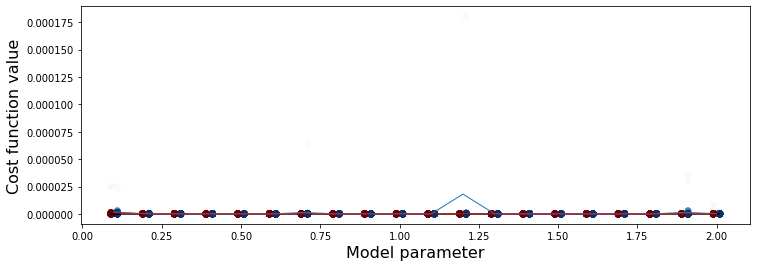

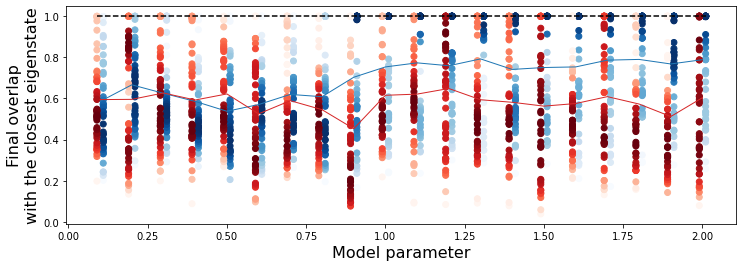

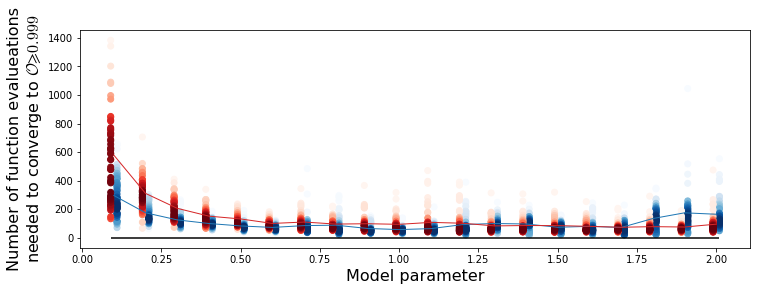

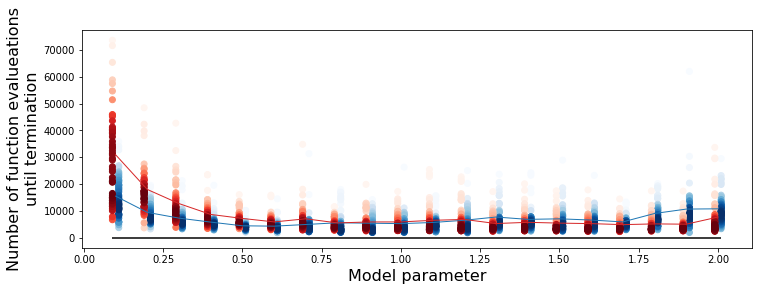

In [20]:
x_axis = pars
dif = (pars[1] - pars[0]) / 10

ss = 1

p = 0.0
cmap = plt.get_cmap('Blues')
colors = cmap(np.linspace(p, 1, cmap.N))
cmap_uni = LinearSegmentedColormap.from_list('part', colors)
cmap = plt.get_cmap('Reds')
colors = cmap(np.linspace(p, 1, cmap.N))
cmap_var = LinearSegmentedColormap.from_list('part', colors)


plt.figure(figsize=figsize)
if with_legends == True:
    x = np.array([x_axis[0] + dif] * len(uni_values[0]))
    e = np.array(uni_values[0])
    plt.scatter(x, e, color='tab:blue', label=r'$F_Q$', s=1)
    x = np.array([x_axis[0] - dif] * len(var_values[0]))
    e = np.array(var_values[0])
    plt.scatter(x, e, color='tab:red', label=r'$F_H$', s=1)
    plt.legend(markerscale=7, fontsize=fontsize)
if with_means == True:
    uni_means = []
    var_means = []
    for i in range(ss, len(x_axis)):
        uni_means.append(np.mean(uni_values[i]))
        var_means.append(np.mean(var_values[i]))
    plt.plot(x_axis[ss:], uni_means, color='tab:blue', linewidth=linewidth)
    plt.plot(x_axis[ss:], var_means, color='tab:red', linewidth=linewidth)
for i in range(ss, len(x_axis)):
    x = np.array([x_axis[i] + dif] * len(uni_values[i]))
    e = np.array(uni_values[i])
    c = gaussian_kde(uni_values[i])(uni_values[i])
    idx = c.argsort()
    x, e, c = x[idx], e[idx], c[idx]
    plt.scatter(x, e, c=c, cmap=cmap_uni)
    
    x = np.array([x_axis[i] - dif] * len(var_values[i]))
    e = np.array(var_values[i])
    c = gaussian_kde(var_values[i])(var_values[i])
    idx = c.argsort()
    x, e, c = x[idx], e[idx], c[idx]
    plt.scatter(x, e, c=c, cmap=cmap_var)
# plt.xticks(x_axis, x_axis)
plt.xlabel('Model parameter', fontsize=fontsize)
plt.ylabel(r'Cost function value', fontsize=fontsize)
plt.hlines(y=0, xmin=x_axis[ss:][0] - dif, xmax=x_axis[ss:][-1] + dif, colors='black', linestyles='solid')
plt.savefig(fig_name + '-values-' + 'intensity.pdf', bbox_inches='tight')
plt.show()


plt.figure(figsize=figsize)
if with_legends == True:
    x = np.array([x_axis[0] + dif] * len(uni_overlaps[0]))
    e = np.array(uni_overlaps[0])
    plt.scatter(x, e, color='tab:blue', label=r'$F_Q$', s=1)
    x = np.array([x_axis[0] - dif] * len(var_overlaps[0]))
    e = np.array(var_overlaps[0])
    plt.scatter(x, e, color='tab:red', label=r'$F_H$', s=1)
    plt.legend(markerscale=7)
if with_means == True:
    uni_means = []
    var_means = []
    for i in range(ss, len(x_axis)):
        uni_means.append(np.mean(uni_overlaps[i]))
        var_means.append(np.mean(var_overlaps[i]))
    plt.plot(x_axis[ss:], uni_means, color='tab:blue', linewidth=linewidth)
    plt.plot(x_axis[ss:], var_means, color='tab:red', linewidth=linewidth)
for i in range(ss, len(x_axis)):
    x = np.array([x_axis[i] + dif] * len(uni_overlaps[i]))
    e = np.array(uni_overlaps[i])
    c = gaussian_kde(uni_overlaps[i])(uni_overlaps[i])
    idx = c.argsort()
    x, e, c = x[idx], e[idx], c[idx]
    plt.scatter(x, e, c=c, cmap=cmap_uni)
    
    x = np.array([x_axis[i] - dif] * len(var_overlaps[i]))
    e = np.array(var_overlaps[i])
    c = gaussian_kde(var_overlaps[i])(var_overlaps[i])
    idx = c.argsort()
    x, e, c = x[idx], e[idx], c[idx]
    plt.scatter(x, e, c=c, cmap=cmap_var)
plt.xlabel('Model parameter', fontsize=fontsize)
plt.ylabel('Final overlap\nwith the closest eigenstate', fontsize=fontsize)
# plt.hlines(y=0, xmin=x_axis[0] - dif, xmax=x_axis[-1] + dif, colors='black', linestyles='solid')
plt.hlines(y=1, xmin=x_axis[ss:][0] - dif, xmax=x_axis[ss:][-1] + dif, colors='black', linestyles='dashed')
# plt.grid()
plt.savefig(fig_name + '-overlap-' + 'intensity.pdf', bbox_inches='tight')
plt.show()


plt.figure(figsize=figsize)
if with_legends == True:
    x = np.array([x_axis[0] + dif] * len(uni_convergence_nfevs_threshold[0]))
    e = np.array(uni_convergence_nfevs_threshold[0])
    plt.scatter(x, e, color='tab:blue', label=r'$F_Q$', s=1)
    x = np.array([x_axis[0] - dif] * len(var_convergence_nfevs_threshold[0]))
    e = np.array(var_convergence_nfevs_threshold[0])
    plt.scatter(x, e, color='tab:red', label=r'$F_H$', s=1)
    plt.legend(markerscale=7, fontsize=16)
if with_means == True:
    uni_means = []
    var_means = []
    for i in range(ss, len(x_axis)):
        uni_means.append(np.mean(uni_convergence_nfevs_threshold[i]))
        var_means.append(np.mean(var_convergence_nfevs_threshold[i]))
    plt.plot(x_axis[ss:], uni_means, color='tab:blue', linewidth=linewidth)
    plt.plot(x_axis[ss:], var_means, color='tab:red', linewidth=linewidth)
for i in range(ss, len(x_axis)):
    x = np.array([x_axis[i] + dif] * len(uni_convergence_nfevs_threshold[i]))
    e = np.array(uni_convergence_nfevs_threshold[i])
    c = gaussian_kde(uni_convergence_nfevs_threshold[i])(uni_convergence_nfevs_threshold[i])
    idx = c.argsort()
    x, e, c = x[idx], e[idx], c[idx]
    plt.scatter(x, e, c=c, cmap=cmap_uni)
    
    x = np.array([x_axis[i] - dif] * len(var_convergence_nfevs_threshold[i]))
    e = np.array(var_convergence_nfevs_threshold[i])
    c = gaussian_kde(var_convergence_nfevs_threshold[i])(var_convergence_nfevs_threshold[i])
    idx = c.argsort()
    x, e, c = x[idx], e[idx], c[idx]
    plt.scatter(x, e, c=c, cmap=cmap_var)
plt.xlabel('Model parameter', fontsize=fontsize)
plt.ylabel('Number of function evalueations\n' + r'needed to converge to $\mathcal{O} \geqslant 0.999$', fontsize=fontsize)
plt.hlines(y=0, xmin=x_axis[ss:][0] - dif, xmax=x_axis[ss:][-1] + dif, colors='black', linestyles='solid')
# plt.grid()
plt.savefig(fig_name + '-value_convergance-' + 'intensity.pdf', bbox_inches='tight')
plt.show()


plt.figure(figsize=figsize)
if with_legends == True:
    x = np.array([x_axis[0] + dif] * len(uni_convergence_nfevs[0]))
    e = np.array(uni_convergence_nfevs[0])
    plt.scatter(x, e, color='tab:blue', label=r'$F_Q$', s=1)
    x = np.array([x_axis[0] - dif] * len(var_convergence_nfevs[0]))
    e = np.array(var_convergence_nfevs[0])
    plt.scatter(x, e, color='tab:red', label=r'$F_H$', s=1)
    plt.legend(markerscale=7, fontsize=16)
if with_means == True:
    uni_means = []
    var_means = []
    for i in range(ss, len(x_axis)):
        uni_means.append(np.mean(uni_convergence_nfevs[i]))
        var_means.append(np.mean(var_convergence_nfevs[i]))
    plt.plot(x_axis[ss:], uni_means, color='tab:blue', linewidth=linewidth)
    plt.plot(x_axis[ss:], var_means, color='tab:red', linewidth=linewidth)
for i in range(ss, len(x_axis)):
    x = np.array([x_axis[i] + dif] * len(uni_convergence_nfevs[i]))
    e = np.array(uni_convergence_nfevs[i])
    c = gaussian_kde(uni_convergence_nfevs[i])(uni_convergence_nfevs[i])
    idx = c.argsort()
    x, e, c = x[idx], e[idx], c[idx]
    plt.scatter(x, e, c=c, cmap=cmap_uni, label=r'$F_Q$')
        
    x = np.array([x_axis[i] - dif] * len(var_convergence_nfevs[i]))
    e = np.array(var_convergence_nfevs[i])
    c = gaussian_kde(var_convergence_nfevs[i])(var_convergence_nfevs[i])
    idx = c.argsort()
    x, e, c = x[idx], e[idx], c[idx]
    plt.scatter(x, e, c=c, cmap=cmap_var, label=r'$F_H$')
plt.xlabel('Model parameter', fontsize=fontsize)
plt.ylabel('Number of function evalueations\nuntil termination', fontsize=fontsize)
plt.hlines(y=0, xmin=x_axis[ss:][0] - dif, xmax=x_axis[ss:][-1] + dif, colors='black', linestyles='solid')
# plt.grid()
plt.savefig(fig_name + '-overlap_convergance-' + 'intensity.pdf', bbox_inches='tight')
# plt.xlim(x_axis[1])
plt.show()

In [21]:
uni_overlap_converged_numbers = []
var_overlap_converged_numbers = []
for i in range(len(uni_overlaps)):
    uni_count = 0
    var_count = 0
    for k in range(len(uni_overlaps[i])):
        if uni_overlaps[i][k] > 1 - threshold:
            uni_count += 1
        if var_overlaps[i][k] > 1 - threshold:
            var_count += 1
    uni_overlap_converged_numbers.append(uni_count)
    var_overlap_converged_numbers.append(var_count)

In [22]:
from matplotlib import gridspec

figsize = (12, 9)
fontsize = 16
linewidth = 1
with_legends = False
with_means = True
alpha = 0.75

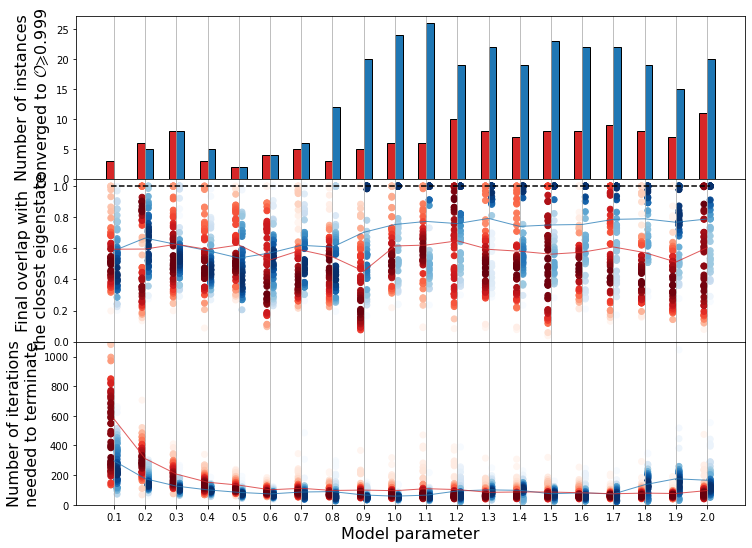

In [23]:
ss = 1

fig = plt.figure(figsize=figsize)
gs = gridspec.GridSpec(3, 1, height_ratios=[1, 1, 1]) 


width = 0.025
ax0 = plt.subplot(gs[0])#
ax0.bar(np.array(x_axis[ss:]) + width/2, uni_overlap_converged_numbers[ss:], width, color='tab:blue', edgecolor='black')
ax0.bar(np.array(x_axis[ss:]) - width/2, var_overlap_converged_numbers[ss:], width, color='tab:red', edgecolor='black')
ax0.set_ylabel('Number of instances\n' + r'converged to $\mathcal{O} \geqslant$' + str(1-threshold), fontsize=fontsize)
ax0.grid(axis='x')
ax0.set_ylim(0)

ax1 = plt.subplot(gs[1], sharex = ax0)# 
if with_means == True:
    uni_means = []
    var_means = []
    for i in range(ss, len(x_axis)):
        uni_means.append(np.mean(uni_overlaps[i]))
        var_means.append(np.mean(var_overlaps[i]))
    ax1.plot(x_axis[ss:], uni_means, color='tab:blue', linewidth=linewidth, alpha=alpha)
    ax1.plot(x_axis[ss:], var_means, color='tab:red', linewidth=linewidth, alpha=alpha)
for i in range(ss, len(x_axis)):
    x = np.array([x_axis[i] + dif] * len(uni_overlaps[i]))
    e = np.array(uni_overlaps[i])
    c = gaussian_kde(uni_overlaps[i])(uni_overlaps[i])
    idx = c.argsort()
    x, e, c = x[idx], e[idx], c[idx]
    plt.scatter(x, e, c=c, cmap=cmap_uni)
    
    x = np.array([x_axis[i] - dif] * len(var_overlaps[i]))
    e = np.array(var_overlaps[i])
    c = gaussian_kde(var_overlaps[i])(var_overlaps[i])
    idx = c.argsort()
    x, e, c = x[idx], e[idx], c[idx]
    ax1.scatter(x, e, c=c, cmap=cmap_var)
ax1.set_ylabel('Final overlap with\nthe closest eigenstate', fontsize=fontsize)
# ax1.hlines(y=0, xmin=x_axis[ss:][0] - dif, xmax=x_axis[ss:][-1] + dif, colors='black', linestyles='solid')
ax1.hlines(y=1, xmin=x_axis[ss:][0] - dif, xmax=x_axis[ss:][-1] + dif, colors='black', linestyles='dashed')
ax1.grid(axis='x')
ax1.set_ylim(0)

ax2 = plt.subplot(gs[2], sharex = ax1) 
plt.setp(ax1.get_xticklabels(), visible=False)
if with_means == True:
    uni_means = []
    var_means = []
    for i in range(ss, len(x_axis)):
        uni_means.append(np.mean(uni_convergence_nfevs_threshold[i]))
        var_means.append(np.mean(var_convergence_nfevs_threshold[i]))
    ax2.plot(x_axis[ss:], uni_means, color='tab:blue', linewidth=linewidth, alpha=alpha)
    ax2.plot(x_axis[ss:], var_means, color='tab:red', linewidth=linewidth, alpha=alpha)
for i in range(ss, len(x_axis)):
    x = np.array([x_axis[i] + dif] * len(uni_convergence_nfevs_threshold[i]))
    e = np.array(uni_convergence_nfevs_threshold[i])
    c = gaussian_kde(uni_convergence_nfevs_threshold[i])(uni_convergence_nfevs_threshold[i])
    idx = c.argsort()
    x, e, c = x[idx], e[idx], c[idx]
    ax2.scatter(x, e, c=c, cmap=cmap_uni)
    
    x = np.array([x_axis[i] - dif] * len(var_convergence_nfevs_threshold[i]))
    e = np.array(var_convergence_nfevs_threshold[i])
    c = gaussian_kde(var_convergence_nfevs_threshold[i])(var_convergence_nfevs_threshold[i])
    idx = c.argsort()
    x, e, c = x[idx], e[idx], c[idx]
    ax2.scatter(x, e, c=c, cmap=cmap_var)
ax2.set_xlabel('Model parameter', fontsize=fontsize)
ax2.set_ylabel('Number of iterations\nneeded to terminate', fontsize=fontsize)
# ax2.hlines(y=0, xmin=x_axis[ss:][0] - dif, xmax=x_axis[ss:][-1] + dif, colors='black', linestyles='solid')
ax2.grid(axis='x')
ax2.set_ylim(0, 1100)

plt.subplots_adjust(hspace=.0)
plt.xticks(x_axis[ss:])

plt.savefig('!!!new-' + fig_name + '-intensity-merged.pdf', bbox_inches='tight')
plt.savefig('!!!new-' + fig_name + '-intensity-merged.png', bbox_inches='tight')
plt.show()

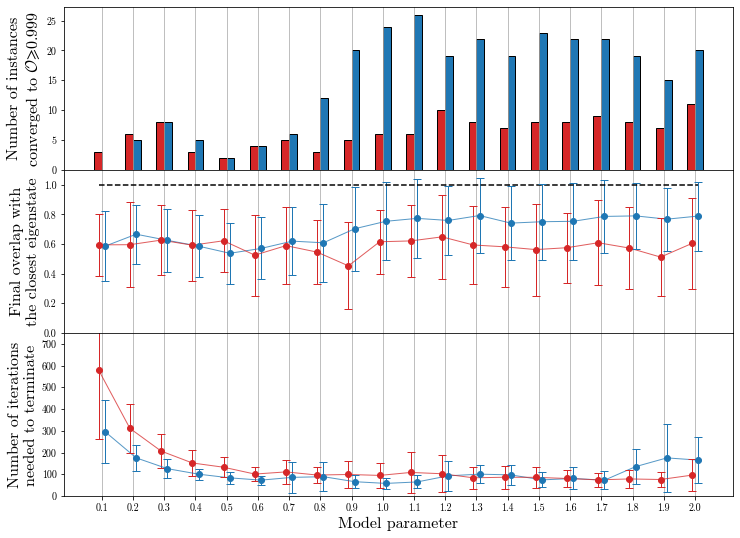

In [76]:
ss = 1

fig = plt.figure(figsize=figsize)
gs = gridspec.GridSpec(3, 1, height_ratios=[1, 1, 1]) 


width = 0.025
ax0 = plt.subplot(gs[0])#
ax0.bar(np.array(x_axis[ss:]) + width/2, uni_overlap_converged_numbers[ss:], width, color='tab:blue', edgecolor='black')
ax0.bar(np.array(x_axis[ss:]) - width/2, var_overlap_converged_numbers[ss:], width, color='tab:red', edgecolor='black')
ax0.set_ylabel('Number of instances\n' + r'converged to $\mathcal{O} \geqslant$' + str(1-threshold), fontsize=fontsize)
ax0.grid(axis='x')
ax0.set_ylim(0)

ax1 = plt.subplot(gs[1], sharex = ax0)
uni_means = []
var_means = []
uni_stds = []
var_stds = []
for i in range(ss, len(x_axis)):
    uni_means.append(np.mean(uni_overlaps[i]))
    var_means.append(np.mean(var_overlaps[i]))  
    uni_stds.append(np.std(uni_overlaps[i]))
    var_stds.append(np.std(var_overlaps[i]))
ax1.plot(x_axis[ss:] + dif, uni_means, color='tab:blue', linewidth=linewidth, alpha=alpha)
ax1.plot(x_axis[ss:] - dif, var_means, color='tab:red', linewidth=linewidth, alpha=alpha)
ax1.errorbar(x_axis[ss:] + dif, uni_means, yerr=uni_stds, color='tab:blue', fmt='o', linewidth=linewidth, capsize=4)
ax1.errorbar(x_axis[ss:] - dif, var_means, yerr=var_stds, color='tab:red', fmt='o', linewidth=linewidth, capsize=4)
ax1.set_ylabel('Final overlap with\nthe closest eigenstate', fontsize=fontsize)
# ax1.hlines(y=0, xmin=x_axis[ss:][0] - dif, xmax=x_axis[ss:][-1] + dif, colors='black', linestyles='solid')
ax1.hlines(y=1, xmin=x_axis[ss:][0] - dif, xmax=x_axis[ss:][-1] + dif, colors='black', linestyles='dashed')
ax1.grid(axis='x')
ax1.set_ylim(0, 1.1)

ax2 = plt.subplot(gs[2], sharex = ax1) 
plt.setp(ax1.get_xticklabels(), visible=False)
uni_means = []
var_means = []
uni_stds = []
var_stds = []
for i in range(ss, len(x_axis)):
    uni_means.append(np.mean(uni_convergence_nfevs_threshold[i]))
    var_means.append(np.mean(var_convergence_nfevs_threshold[i]))  
    uni_stds.append(np.std(uni_convergence_nfevs_threshold[i]))
    var_stds.append(np.std(var_convergence_nfevs_threshold[i]))
ax2.plot(x_axis[ss:] + dif, uni_means, color='tab:blue', linewidth=linewidth, alpha=alpha)
ax2.plot(x_axis[ss:] - dif, var_means, color='tab:red', linewidth=linewidth, alpha=alpha)
ax2.errorbar(x_axis[ss:] + dif, uni_means, yerr=uni_stds, color='tab:blue', fmt='o', linewidth=linewidth, capsize=4, markersize=None)
ax2.errorbar(x_axis[ss:] - dif, var_means, yerr=var_stds, color='tab:red', fmt='o', linewidth=linewidth, capsize=4, markersize=None)
ax2.set_xlabel('Model parameter', fontsize=fontsize)
ax2.set_ylabel('Number of iterations\nneeded to terminate', fontsize=fontsize)
ax2.grid(axis='x')
ax2.set_ylim(0, 750)

plt.subplots_adjust(hspace=.0)
plt.xticks(x_axis[ss:])

plt.savefig('!!!new-' + fig_name + '-intensity-merged_std.pdf', bbox_inches='tight')
plt.savefig('!!!new-' + fig_name + '-intensity-merged_std.png', bbox_inches='tight')
plt.show()

In [27]:
import matplotlib as mpl
import matplotlib.font_manager as font_manager
plt.rcParams['font.family']='serif'
cmfont = font_manager.FontProperties(fname=mpl.get_data_path() + '/fonts/ttf/cmr10.ttf')
plt.rcParams['font.serif']=cmfont.get_name()
plt.rcParams['mathtext.fontset']='cm'
plt.rcParams['axes.unicode_minus']=False

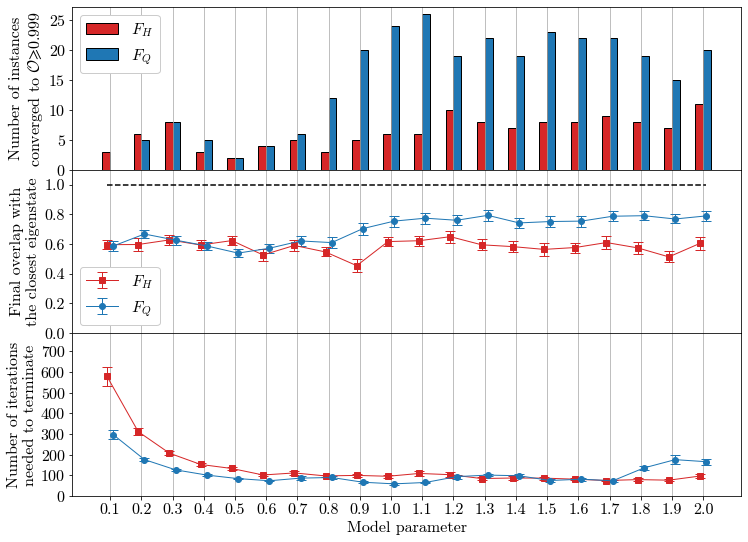

In [85]:
fontsize = 16

ss = 1

fig = plt.figure(figsize=figsize)
gs = gridspec.GridSpec(3, 1, height_ratios=[1, 1, 1]) 


width = 0.025
ax0 = plt.subplot(gs[0])#
ax0.bar(np.array(x_axis[ss:]) - width/2, var_overlap_converged_numbers[ss:], width, color='tab:red', edgecolor='black', label=r'$F_H$')
ax0.bar(np.array(x_axis[ss:]) + width/2, uni_overlap_converged_numbers[ss:], width, color='tab:blue', edgecolor='black', label=r'$F_Q$')
ax0.set_ylabel('Number of instances\n' + r'converged to $\mathcal{O} \geqslant$' + str(1-threshold), fontsize=fontsize)
ax0.grid(axis='x')
ax0.set_ylim(0)
ax0.legend(framealpha=1, fontsize=fontsize)
plt.yticks(fontsize=fontsize)

ax1 = plt.subplot(gs[1], sharex = ax0)
uni_means = []
var_means = []
uni_stds = []
var_stds = []
for i in range(ss, len(x_axis)):
    uni_means.append(np.mean(uni_overlaps[i]))
    var_means.append(np.mean(var_overlaps[i]))  
    uni_stds.append(sem(uni_overlaps[i]))
    var_stds.append(sem(var_overlaps[i]))
ax1.errorbar(x_axis[ss:] - dif, var_means, yerr=var_stds, color='tab:red', fmt='s-', linewidth=linewidth, capsize=5, label=r'$F_H$')
ax1.errorbar(x_axis[ss:] + dif, uni_means, yerr=uni_stds, color='tab:blue', fmt='o-', linewidth=linewidth, capsize=5, label=r'$F_Q$')
ax1.set_ylabel('Final overlap with\nthe closest eigenstate', fontsize=fontsize)
# ax1.hlines(y=0, xmin=x_axis[ss:][0] - dif, xmax=x_axis[ss:][-1] + dif, colors='black', linestyles='solid')
ax1.hlines(y=1, xmin=x_axis[ss:][0] - dif, xmax=x_axis[ss:][-1] + dif, colors='black', linestyles='dashed')
ax1.grid(axis='x')
ax1.set_ylim(0, 1.1)
ax1.legend(loc=3, framealpha=1, fontsize=fontsize)
plt.yticks(fontsize=fontsize)

ax2 = plt.subplot(gs[2], sharex = ax1) 
plt.setp(ax1.get_xticklabels(), visible=False)
uni_means = []
var_means = []
uni_stds = []
var_stds = []
for i in range(ss, len(x_axis)):
    uni_means.append(np.mean(uni_convergence_nfevs_threshold[i]))
    var_means.append(np.mean(var_convergence_nfevs_threshold[i]))  
    uni_stds.append(sem(uni_convergence_nfevs_threshold[i]))
    var_stds.append(sem(var_convergence_nfevs_threshold[i]))
ax2.errorbar(x_axis[ss:] - dif, var_means, yerr=var_stds, color='tab:red', fmt='s-', linewidth=linewidth, capsize=5)
ax2.errorbar(x_axis[ss:] + dif, uni_means, yerr=uni_stds, color='tab:blue', fmt='o-', linewidth=linewidth, capsize=5)
ax2.set_xlabel('Model parameter', fontsize=fontsize)
ax2.set_ylabel('Number of iterations\nneeded to terminate', fontsize=fontsize)
ax2.grid(axis='x')
ax2.set_ylim(0, 790)

plt.subplots_adjust(hspace=.0)
plt.xticks(x_axis[ss:], fontsize=fontsize)
plt.yticks(fontsize=fontsize)

# plt.savefig('!!!new-' + fig_name + '-intensity-merged_sem.pdf', bbox_inches='tight')
# plt.savefig('!!!new-' + fig_name + '-intensity-merged_sem.png', bbox_inches='tight')
plt.savefig('figure4.pdf', bbox_inches='tight')
plt.show()

# Hamiltonian test

In [10]:
from functools import reduce
from itertools import product

In [12]:
def string_to_matrix(operator_string):
    
    qubits_number = len(operator_string)

    if operator_string[0] == 'I':
        operator = I_np
    elif operator_string[0] == 'X':
        operator = X_np
    elif operator_string[0] == 'Y':
        operator = Y_np
    elif operator_string[0] == 'Z':
        operator = Z_np

    for k in range(1, qubits_number):
        if operator_string[k] == 'I':
            operator = kron(operator, I_np)
        elif operator_string[k] == 'X':
            operator = kron(operator, X_np)
        elif operator_string[k] == 'Y':
            operator = kron(operator, Y_np)
        elif operator_string[k] == 'Z':
            operator = kron(operator, Z_np)
            
    return operator

In [48]:
def decompose_to_paulies(n_qubits, hermitian):
    
    d = 2**n_qubits
    
    hermitian_dict = {}
        
    paulies = ['I', 'X', 'Y', 'Z']
    bases = list(product(*[paulies for i in range(n_qubits)]))
    
    for basis in bases:
        observable = string_to_matrix(basis)
        result = trace(hermitian.dot(observable)).real
        
        if result != 0:
            label = ''.join(basis) # strange pythonic thing for concatinating chars in a list
            hermitian_dict[label] = result / d
    
    return hermitian_dict

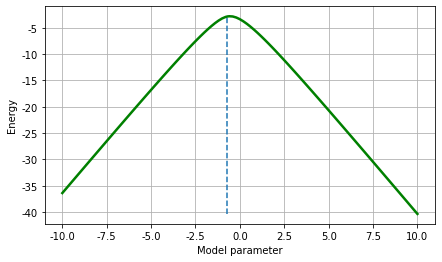

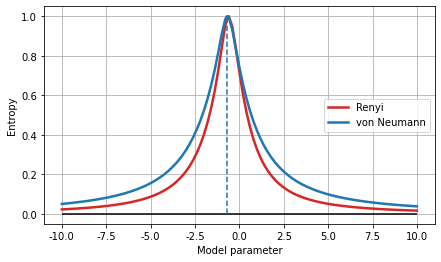

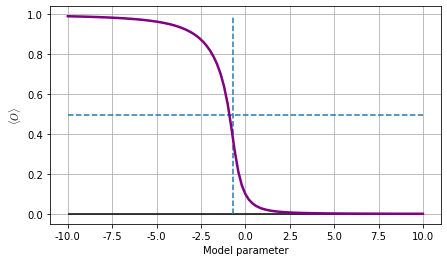

In [111]:
n_qubits = 8
d = 2**n_qubits

I = reduce(kron, [I_np]*n_qubits)
order_obs = 1j * np.zeros((d, d))
for i in range(n_qubits):
    op1 = [I_np]*i + [Z_np] + [I_np]*(n_qubits - 1 - i)
    op1 = reduce(kron, op1)
    op1 = I + (-1)**(i + 0) * op1
    for j in range(i+1, n_qubits):
        op2 = [I_np]*j + [Z_np] + [I_np]*(n_qubits - 1 - j)
        op2 = reduce(kron, op2)
        op2 = I + (-1)**(j + 0) * op2
        order_obs = order_obs + op1.dot(op2)
order_obs = order_obs / (2*n_qubits*(n_qubits-1)) 
        
w = 1
g = 1
ms = np.sort(list(np.linspace(-10, 10, 101)) + [-0.7])
subspace_qubits = sorted(random.sample([i+1 for i in range(n_qubits)], int(n_qubits/2)))
subspace_qubits = [1, 2, 3, 4]

energies = []
entropies_r = []
entropies_vn = []
order_vals = []

for m in ms:
    
    ham = np.flip(schwinger_model(n_qubits, w, m, g))
    evals, evecs = eigh(ham)
    energies.append(evals[0])
    gs = evecs[:,0]
    gs_dm = np.outer(gs, gs.conj().T)
    gs_dm_p = partial_trace(gs_dm, n_qubits, subspace_qubits)
    
    order_vals.append((gs.dot(order_obs).dot(gs.conj().T)).real)
    
    entropies_r.append(renyi_entropy(gs_dm_p))
    entropies_vn.append(von_neumann_entropy(gs_dm_p))
  

plt.figure(figsize=(7, 4))
plt.plot(ms, energies, color='green', linewidth=2.5)
plt.vlines(x=-0.7, ymin=min(energies), ymax=max(energies), linestyles='dashed')
# plt.vlines(x=-0.5, ymin=0, ymax=max(max(entropies_r/max(entropies_r)), max(entropies_vn/max(entropies_vn))), colors='grey', linestyles='dashed')
plt.grid()
plt.xlabel(r'Model parameter')
plt.ylabel('Energy')
plt.show()

plt.figure(figsize=(7, 4))
plt.plot(ms, entropies_r/max(entropies_r), color='tab:red', label='Renyi', linewidth=2.5)
plt.plot(ms, entropies_vn/max(entropies_vn), color='tab:blue', label='von Neumann', linewidth=2.5)
plt.hlines(y=0, xmin=ms[0], xmax=ms[-1], colors='black', linestyles='solid')
plt.vlines(x=-0.7, ymin=0, ymax=max(max(entropies_r/max(entropies_r)), max(entropies_vn/max(entropies_vn))), linestyles='dashed')
# plt.vlines(x=-0.5, ymin=0, ymax=max(max(entropies_r/max(entropies_r)), max(entropies_vn/max(entropies_vn))), colors='grey', linestyles='dashed')
plt.legend(loc=5)
plt.grid()
plt.xlabel(r'Model parameter')
plt.ylabel('Entropy')
plt.show()

plt.figure(figsize=(7, 4))
plt.plot(ms, order_vals, color='Purple', label='Renyi', linewidth=2.5)
plt.hlines(y=0, xmin=ms[0], xmax=ms[-1], colors='black', linestyles='solid')
plt.hlines(y=max(order_vals)/2, xmin=ms[0], xmax=ms[-1], linestyles='dashed')
plt.vlines(x=-0.7, ymin=0, ymax=max(order_vals), linestyles='dashed')
# plt.vlines(x=-0.5, ymin=0, ymax=max(order_vals), colors='grey', linestyles='dashed')
plt.grid()
plt.xlabel(r'Model parameter')
plt.ylabel(r'$\langle O \rangle$')
plt.show()

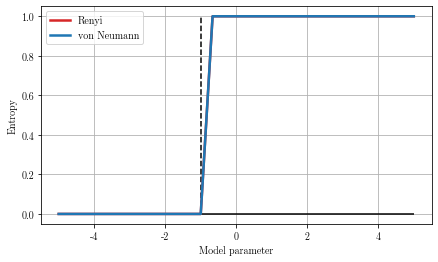

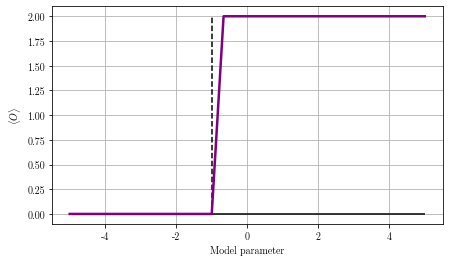

In [88]:
n_qubits = 2
d = 2**n_qubits

I = reduce(kron, [I_np]*n_qubits)
order_obs = 1j * np.zeros((d, d))
for i in range(n_qubits):
    op1 = [I_np]*i + [Z_np] + [I_np]*(n_qubits - 1 - i)
    op1 = reduce(kron, op1)
    op1 = I + (-1)**(i + 0) * op1
    for j in range(i+1, n_qubits):
        op2 = [I_np]*j + [Z_np] + [I_np]*(n_qubits - 1 - j)
        op2 = reduce(kron, op2)
        op2 = I + (-1)**(j + 0) * op2
        order_obs = order_obs + op1.dot(op2)
        
t = 1
vs = list(np.linspace(-5, 5, 31))
subspace_qubits = sorted(random.sample([i+1 for i in range(n_qubits)], int(n_qubits/2)))

entropies_r = []
entropies_vn = []
order_vals = []

for v in vs:
    
#     fh = OH.fermi_hubbard(n_qubits, 1, t, v, periodic=True, spinless=True)
#     jw = jordan_wigner(fh)
#     sparse_op_jw = OT.get_sparse_operator(jw)
#     ham = sparse_op_jw.toarray()
    ham = hubbard_model(n_qubits, t, v, 0)
    
    gs = eigh(ham)[1][:,0]
    gs_dm = np.outer(gs, gs.conj().T)
    gs_dm_p = partial_trace(gs_dm, n_qubits, subspace_qubits)
    
    order_vals.append((gs.dot(order_obs).dot(gs.conj().T)).real)
    
    entropies_r.append(renyi_entropy(gs_dm_p))
    entropies_vn.append(von_neumann_entropy(gs_dm_p))
    
plt.figure(figsize=(7, 4))
plt.plot(vs, entropies_r/max(entropies_r), color='tab:red', label='Renyi', linewidth=2.5)
plt.plot(vs, entropies_vn/max(entropies_vn), color='tab:blue', label='von Neumann', linewidth=2.5)
plt.hlines(y=0, xmin=vs[0], xmax=vs[-1], colors='black', linestyles='solid')
plt.vlines(x=-t, ymin=0, ymax=max(max(entropies_r/max(entropies_r)), max(entropies_vn/max(entropies_vn))), linestyles='dashed')
# plt.hlines(y=1, xmin=s, xmax=k, colors='green', linestyles='dashed')
# plt.xlim(0, k)
# plt.ylim(ymax=1.1)
plt.legend()
plt.grid()
plt.xlabel(r'Model parameter')
plt.ylabel('Entropy')
plt.show()


plt.figure(figsize=(7, 4))
plt.plot(vs, order_vals, color='purple', label='Renyi', linewidth=2.5)
plt.hlines(y=0, xmin=vs[0], xmax=vs[-1], colors='black', linestyles='solid')
# plt.hlines(y=max(order_vals)/2, xmin=vs[0], xmax=vs[-1], linestyles='dashed')
plt.vlines(x=-t, ymin=0, ymax=max(order_vals), linestyles='dashed')
plt.grid()
plt.xlabel(r'Model parameter')
plt.ylabel(r'$\langle O \rangle$')
plt.show()

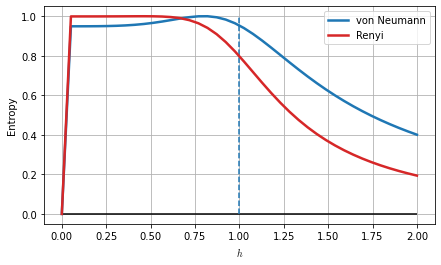

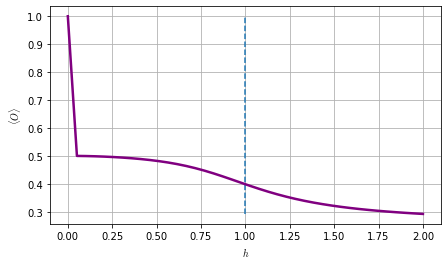

In [106]:
n_qubits = 6
d = 2**n_qubits

N = n_qubits
I = reduce(kron, [I_np]*n_qubits)
order_obs = 1j * np.zeros((d, d))
for i in range(n_qubits):
    op1 = [I_np]*i + [Z_np] + [I_np]*(n_qubits - 1 - i)
    op1 = reduce(kron, op1)
    op1 = I + (-1)**(i + 0) * op1
    for j in range(i+1, n_qubits):
        op2 = [I_np]*j + [Z_np] + [I_np]*(n_qubits - 1 - j)
        op2 = reduce(kron, op2)
        op2 = I + (-1)**(j + 0) * op2
        order_obs = order_obs + op1.dot(op2)
order_obs = order_obs / (2*N*(N-1)) 

vs = np.sort(list(np.linspace(0.0, 2.0, 40)))
subspace_qubits = sorted(random.sample([i+1 for i in range(n_qubits)], int(n_qubits/2)))

entropies_r = []
entropies_vn = []
order_vals = []

for v in vs:
#     print(v)
#     hamiltonian_dictionary = heisenberg_model(n_qubits, 1, 1, v, 0)
    hamiltonian_dictionary = ising_model(n_qubits, 1, v)
    ham = hamiltonian_dictionary_to_matrix(hamiltonian_dictionary)
    
    gs = eigh(ham)[1][:,0]
    gs_dm = np.outer(gs, gs.conj().T)
    gs_dm_p = partial_trace(gs_dm, n_qubits, subspace_qubits)
    
    order_vals.append((gs.dot(order_obs).dot(gs.conj().T)).real)
    
    entropies_r.append(renyi_entropy(gs_dm_p))
    entropies_vn.append(von_neumann_entropy(gs_dm_p))
    
plt.figure(figsize=(7, 4))
plt.plot(vs, entropies_vn/max(entropies_vn), color='tab:blue', label='von Neumann', linewidth=2.5)
plt.plot(vs, entropies_r/max(entropies_r), color='tab:red', label='Renyi', linewidth=2.5)
plt.hlines(y=0, xmin=vs[0], xmax=vs[-1], colors='black', linestyles='solid')
plt.vlines(x=1, ymin=0, ymax=max(entropies_vn/max(entropies_vn)), linestyles='dashed')
# plt.hlines(y=1, xmin=s, xmax=k, colors='green', linestyles='dashed')
# plt.xlim(0, k)
# plt.ylim(ymax=1.1)
plt.grid()
plt.legend()
plt.xlabel(r'$h$')
plt.ylabel('Entropy')
plt.show()


plt.figure(figsize=(7, 4))
plt.plot(vs, order_vals, color='purple', label='order', linewidth=2.5)
plt.vlines(x=1, ymin=min(order_vals), ymax=max(order_vals), linestyles='dashed')
plt.grid()
plt.xlabel(r'$h$')
plt.ylabel(r'$\langle O \rangle$')
plt.show()

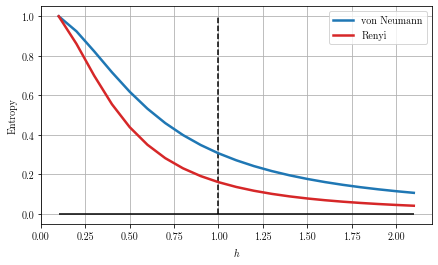

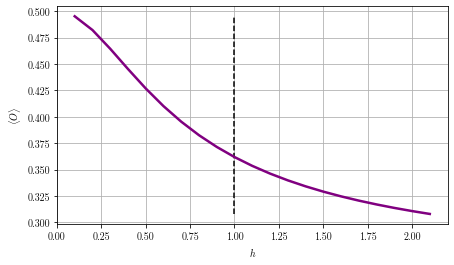

In [77]:
n_qubits = 2
d = 2**n_qubits

N = n_qubits
I = reduce(kron, [I_np]*n_qubits)
order_obs = 1j * np.zeros((d, d))
for i in range(n_qubits):
    op1 = [I_np]*i + [Z_np] + [I_np]*(n_qubits - 1 - i)
    op1 = reduce(kron, op1)
    op1 = I + (-1)**(i + 0) * op1
    for j in range(i+1, n_qubits):
        op2 = [I_np]*j + [Z_np] + [I_np]*(n_qubits - 1 - j)
        op2 = reduce(kron, op2)
        op2 = I + (-1)**(j + 0) * op2
        order_obs = order_obs + op1.dot(op2)
order_obs = order_obs / (2*N*(N-1)) 

vs = np.sort(list(np.linspace(0.1, 2.1, 21)))
subspace_qubits = sorted(random.sample([i+1 for i in range(n_qubits)], int(n_qubits/2)))

entropies_r = []
entropies_vn = []
order_vals = []

for v in vs:
    
    hamiltonian_dictionary = ising_model(n_qubits, 1, v)
    ham = hamiltonian_dictionary_to_matrix(hamiltonian_dictionary)
    
    gs = eigh(ham)[1][:,0]
    gs_dm = np.outer(gs, gs.conj().T)
    gs_dm_p = partial_trace(gs_dm, n_qubits, subspace_qubits)
    
    order_vals.append((gs.dot(order_obs).dot(gs.conj().T)).real)
    
    entropies_r.append(renyi_entropy(gs_dm_p))
    entropies_vn.append(von_neumann_entropy(gs_dm_p))
    
plt.figure(figsize=(7, 4))
plt.plot(vs, entropies_vn/max(entropies_vn), color='tab:blue', label='von Neumann', linewidth=2.5)
plt.plot(vs, entropies_r/max(entropies_r), color='tab:red', label='Renyi', linewidth=2.5)
plt.hlines(y=0, xmin=vs[0], xmax=vs[-1], colors='black', linestyles='solid')
plt.vlines(x=1, ymin=0, ymax=max(entropies_vn/max(entropies_vn)), linestyles='dashed')
# plt.hlines(y=1, xmin=s, xmax=k, colors='green', linestyles='dashed')
# plt.xlim(0, k)
# plt.ylim(ymax=1.1)
plt.grid()
plt.legend()
plt.xlabel(r'$h$')
plt.ylabel('Entropy')
plt.show()


plt.figure(figsize=(7, 4))
plt.plot(vs, order_vals, color='purple', label='order', linewidth=2.5)
plt.vlines(x=1, ymin=min(order_vals), ymax=max(order_vals), linestyles='dashed')
plt.grid()
plt.xlabel(r'$h$')
plt.ylabel(r'$\langle O \rangle$')
plt.show()